In [ ]:
import numpy as np
from numpy import linalg as LA
import random
from collections import defaultdict
from functools import partial
import math
import copy

# state of each agent (UAV)
class LocalState():
    def __init__(self, k, l, pos, velocity, r_c, r_s, num_agents, action_num):
        self.k = k
        self.l = l
        self.pos = pos
        self.velocity = velocity
        self.acc = 0
        self.r_c = r_c
        self.r_s = r_s
        self.action_num = action_num
        self.neighbours = []
        self.action_n = []
        
        self.gamma_map = np.zeros(((int)(k), (int)(l))) # coverage map
        self.prev_gamma_map = []
        self.prev_target_gamma_idx = {}
        self.target_gamma_idx = {} # indice of agents' gamma points
        for i in range(num_agents):
            # if i == agent_id:
            #     continue
            self.target_gamma_idx[i] = [-1, -1]

        self.Q = defaultdict(partial(np.zeros, self.action_num)) # Q table
        # self.Q = defaultdict(partial(np.random.rand * 0.1, self.action_num))
        self.Qts = {} # mappingm between state-action and the mapping of next state and corresponding action space

        self.tra_map = np.zeros(((int)(k), (int)(l)))
        self.untraversed_idx = None
        self.done = False
        self.prev_global_map = []
        self.prev_count_map = []
        

class Environment():
    def __init__(self, m, n, r_c, r_s, d, h, w, alpha, beta, c_alpha, c1_gamma, c2_gamma, epsilon, c_r, t_step, v_max, c1_T, c2_T, r_ref, lambda_, action_num, num_agents):
        self.r_c = r_c
        self.r_s = r_s
        self.d = d
        self.h = h
        self.w = w
        self.alpha = alpha
        self.beta = beta
        self.c_alpha = c_alpha
        self.c1_gamma = c1_gamma
        self.c2_gamma = c2_gamma
        self.c1_T = c1_T
        self.c2_T = c2_T
        self.r_ref = r_ref
        self.lambda_ = lambda_
        self.t_step = t_step
        self.c_r = c_r
        self.v_max = v_max
        self.m = m   # length
        self.n = n   # width
        self.k = (int)(np.ceil(n / (np.sqrt(2) * self.r_s)))   # rows
        self.l = (int)(np.ceil(m / (np.sqrt(2) * self.r_s)))   # columns
        self.num_agents = num_agents
        self.action_num = action_num
        self.epsilon = epsilon   # range to decide if target pos is reached
        self.T = 0.3
        self.action_gamma_point_mapping = {
              1: [0, 0],
              2: [0, 1],
              3: [-1, 1],
              4: [-1, 0],
              5: [-1, -1],
              6: [0, -1],
              7: [1, -1],
              8: [1, 0],
              9: [1, 1]
        }
        self.count_map = np.zeros(((int)(self.k), (int)(self.l)))
        hrz = ((self.l - 1) * self.m * self.k) / (self.l * self.v_max) + ((self.k - 1) * self.n) / (self.k * self.v_max)
        vtc = ((self.k - 1) * self.n * self.l) / (self.k * self.v_max) + ((self.l - 1) * self.m) / (self.l * self.v_max)
        self.T_min = np.min([hrz, vtc]) / self.num_agents
        self.uavs = [LocalState(self.k, self.l, None, None, self.r_c, self.r_s, self.num_agents, self.action_num) for i in range(self.num_agents)]
        self.uavs_pos = []
        uavs_gamma_p = [[-1, -1] for _ in range(self.num_agents)]
        # ids = [[1, 6], [3, 6], [6, 1]] # untrained_50_170.8
        ids = [[6, 3], [5, 1], [1, 6]] # trained_50_142.3 
        # ids = [[2, 4], [2, 1], [4, 5]] # trained_50_143.3_1rpt_1diag
        for i in range(self.num_agents):
            is_same = True
            while is_same:
                is_same = False
                # index = random.randint(1, num_cells - 2)
                # row = random.randint(1, self.k - 2)
                # col = random.randint(1, self.k - 2)
                row = ids[i][0]
                col = ids[i][1]
                for ag_id in range(self.num_agents):
                    if ag_id == i:
                        continue
                    if (row == uavs_gamma_p[ag_id][0]) and (col == uavs_gamma_p[ag_id][1]):
                        is_same = True
                        break
            uavs_gamma_p[i] = [row, col]
            print([row, col])
            # self.uavs_pos.append(np.array(self.index_to_pos([row, col])) + np.array([0.5 + np.random.rand(1) / 2, 0.5 + np.random.rand(1) / 2]))
            self.uavs_pos.append(np.array(self.index_to_pos([row, col])) + np.array([0.5, 1]))
            # self.uavs_pos.append(np.array(self.index_to_pos([row, col])))

        self.crt_min_T = 100000000
        self.prev_T = 0
        self.rpt_T_count = 0
        self.divert_points = []
        self.update_ac_counts = np.zeros(self.num_agents)

        self.cac_xl = 1
        self.cac_yl = 1 
        self.cac_map = np.zeros(((int)(self.n / self.cac_yl), (int)(self.m / self.cac_xl)))
  
    def index_to_pos(self, index):
        x_l = self.m / self.l
        y_l = self.n / self.k
        pos_x = (index[1] + 0.5) * x_l
        pos_y = self.n - (index[0] + 0.5) * y_l   

        return [pos_x, pos_y]

    def index_to_pos_gnr(self, index):
        # x_l = self.m / self.l
        # y_l = self.n / self.k
        pos_x = (index[1] + 0.5) * self.cac_xl
        pos_y = self.n - (index[0] + 0.5) * self.cac_yl   

        return [pos_x, pos_y]

    def update_cac_map(self):
        for i in range(self.num_agents):
            cur_uav = self.uavs[i]
            for j in range(self.cac_map.shape[0]):
                for k in range(self.cac_map.shape[1]):
                    if LA.norm(np.array(cur_uav.pos) - np.array(self.index_to_pos_gnr([j, k]))) <= self.r_s:  
                        self.cac_map[j, k] = 1

        return np.sum(self.cac_map[:, :]) / (self.cac_map.shape[0] * self.cac_map.shape[1])

    def pos_to_index(self, pos):
        x_l = self.m / self.l
        y_l = self.n / self.k
        # col = int(pos[0] / x_l - 0.5)
        # row = int((self.n - pos[1]) / y_l - 0.5)
        col = pos[0] / x_l - 0.5
        row = (self.n - pos[1]) / y_l - 0.5

        return [row, col]

    def update_Qts(self, agent_id, obs, next_obs, action, action_space):
        cur_uav = self.uavs[agent_id]
        if obs in cur_uav.Qts:
            cur_uav.Qts[obs][action] = {}
            cur_uav.Qts[obs][action][next_obs] = action_space
        else:
            cur_uav.Qts[obs] = [{} for _ in range(self.action_num)]
            cur_uav.Qts[obs][action] = {}
            cur_uav.Qts[obs][action][next_obs] = action_space

    def MAS_update(self, agent_id, action):
        agent_ids = list(range(self.num_agents))
        del agent_ids[agent_id]
        # print(agent_ids)
        cur_uav = self.uavs[agent_id]

        # target_gamma_idx = np.array(cur_uav.target_gamma_idx[agent_id]) + np.array(self.action_gamma_point_mapping[action])
        # if is_new_target:
        #     cur_uav.velocity = [0, 0]
        if action != 1:
            cur_uav.target_gamma_idx[agent_id] = np.array(cur_uav.target_gamma_idx[agent_id]) + np.array(self.action_gamma_point_mapping[action])
            # cur_uav.velocity = [0, 0]
        # print("uav ", agent_id, " ", cur_uav.target_gamma_idx[agent_id])

        # update acceleration
        cq_alpha = 0
        for id in agent_ids:
            delta_pos = np.array(self.uavs[id].pos) - np.array(cur_uav.pos)
            delta_pos_mag = LA.norm(delta_pos)
            if delta_pos_mag <= self.r_c:
                z_sigma = np.sqrt(1 + np.square(delta_pos_mag)) - 1
                z_p = z_sigma / self.d
                if z_p >= 0 and z_p < self.h:
                    p_h = 1
                elif z_p >= self.h and z_p < 1:
                    p_h = 1.0 / 2.0 * (1.0 + math.cos(math.pi * (z_p - self.h) / (1 - self.h)))
                else:
                    p_h = 0
                d_sigma = np.sqrt(1 + np.square(self.d)) - 1
                p_sigma = z_sigma - d_sigma
                phi_r = p_sigma / np.sqrt(1 + np.square(p_sigma)) - 1
                phi = p_h * phi_r
                sigma = delta_pos / np.sqrt(1 + np.square(delta_pos_mag))
                cq_alpha += phi * sigma
                # print("agent ", id, " repulsive force = ", phi * sigma)
        cq_alpha = self.c_alpha * cq_alpha
        target_gamma_pos = self.index_to_pos(cur_uav.target_gamma_idx[agent_id])
        cq_gamma = -self.c1_gamma * (np.array(cur_uav.pos) - np.array(target_gamma_pos)) - self.c2_gamma * np.array(cur_uav.velocity)
        cq = cq_alpha + cq_gamma
        # cq = cq_gamma
        # print("cq_alpha = ", cq_alpha)
        # print("cq_gamma = ", cq_gamma)

        # print("target_gamma_pos =", target_gamma_pos)
        # print("mag of cq_alpha = ", LA.norm(cq_alpha))
        # print("mag of cq_gamma = ", LA.norm(cq_gamma))
        # print("mag of cq = ", LA.norm(cq))

        # print("cur_uav.pos = ", cur_uav.pos)
        # print("target_gamma_pos = ", target_gamma_pos)
        # print("cur_uav.velocity = ", cur_uav.velocity)

        # print("mag of cur_uav.velocity = ", LA.norm(cur_uav.velocity))

        cur_uav.acc = cq
        # if LA.norm(cq) < 0.00000001:
        #     cq = cq_gamma

        # update velocity and position
        prev_vel = np.array(cur_uav.velocity)
        cur_uav.velocity = np.array(cur_uav.velocity) + self.t_step * cq
        v_mag = LA.norm(cur_uav.velocity)
        if v_mag > self.v_max:
            cur_uav.velocity *= self.v_max / v_mag
        # cur_uav.pos = np.array(cur_uav.pos) + self.t_step * np.array(cur_uav.velocity)
        cur_uav.pos = np.array(cur_uav.pos) + self.t_step * (prev_vel + np.array(cur_uav.velocity)) / 2

        # print("distance = ", LA.norm(np.array(cur_uav.pos) - np.array(self.uavs[0].pos)))
        # print("distance = ", LA.norm(np.array(cur_uav.pos) - np.array(self.uavs[1].pos)))
        # print("distance = ", LA.norm(np.array(cur_uav.pos) - np.array(self.uavs[2].pos)))
        # print("distance = ", LA.norm(np.array(cur_uav.pos) - np.array(target_gamma_pos)))

        # print(a)
            # print("target is changed")
        # self.T += self.t_step

    def is_target_reached(self, agent_id):
        cur_uav = self.uavs[agent_id]
        target_pos = self.index_to_pos(cur_uav.target_gamma_idx[agent_id])

        return LA.norm(np.array(cur_uav.pos) - np.array(target_pos)) <= self.epsilon

    def fuse_maps(self, agent_id, action_n, prev_action_n):
        cur_uav = self.uavs[agent_id]
        cur_uav.neighbours = []
        for i in range(self.num_agents):
            if i == agent_id:
                continue
            else:
                if LA.norm(np.array(cur_uav.pos) - np.array(self.uavs[i].pos)) <= self.r_c: 
                    cur_uav.neighbours.append(i)
                    cur_uav.gamma_map[:, :] = np.add(cur_uav.gamma_map[:, :], self.uavs[i].gamma_map[:, :])
                    if action_n[i] == 1:
                        x = self.uavs[i].target_gamma_idx[i][0] - self.action_gamma_point_mapping[prev_action_n[i]][0]
                        y = self.uavs[i].target_gamma_idx[i][1] - self.action_gamma_point_mapping[prev_action_n[i]][1]
                    else:
                        x = self.uavs[i].target_gamma_idx[i][0]
                        y = self.uavs[i].target_gamma_idx[i][1]
                    cur_uav.target_gamma_idx[i] = np.array([x, y])
                    # cur_uav.target_gamma_idx[i] = self.uavs[i].target_gamma_idx[i]
                    # print("neighbour ", i, " is found")
                    # print("communicate")
                    # print(c_maps[i])
                    # print(cur_uav.map[:, :, 1])
                else:
                    cur_uav.target_gamma_idx[i] = [-1, -1]
        cur_uav.gamma_map[:, :] = cur_uav.gamma_map[:, :] != 0

        target_gamma_idx = np.array(cur_uav.target_gamma_idx[agent_id]) + np.array(self.action_gamma_point_mapping[action_n[agent_id]])
        # cur_uav.target_gamma_idx[agent_id] = target_gamma_idx
        target_pos = self.index_to_pos(target_gamma_idx)
        is_target_reached = LA.norm(np.array(cur_uav.pos) - np.array(target_pos)) <= self.epsilon
        # print("distance to target = ", LA.norm(np.array(cur_uav.pos) - np.array(target_pos)))
        # if is_target_reached or (LA.norm(cur_uav.acc) < 0.00001 and LA.norm(np.array(cur_uav.pos) - np.array(target_pos)) < 0.5):
        if is_target_reached:
            # cur_uav.gamma_map[cur_uav.target_gamma_idx[agent_id][0], cur_uav.target_gamma_idx[agent_id][1]] = 1
            # # cur_uav.tra_map = np.zeros((self.k, self.l))
            # cur_uav.tra_map[cur_uav.target_gamma_idx[agent_id][0], cur_uav.target_gamma_idx[agent_id][1]] = np.amax(cur_uav.tra_map) + 1
            # self.count_map[cur_uav.target_gamma_idx[agent_id][0], cur_uav.target_gamma_idx[agent_id][1]] += 1
            cur_uav.gamma_map[target_gamma_idx[0], target_gamma_idx[1]] = 1
            # cur_uav.tra_map = np.zeros((self.k, self.l))
            cur_uav.tra_map[target_gamma_idx[0], target_gamma_idx[1]] = np.amax(cur_uav.tra_map) + 1
            self.count_map[target_gamma_idx[0], target_gamma_idx[1]] += 1
            # print()
            # is_target_reached = True
                # print("target is reached")

        return repr([cur_uav.gamma_map, cur_uav.target_gamma_idx])

    def update_target_gamma_point(self, agent_id, action):
        cur_uav = self.uavs[agent_id]
        cur_uav.target_gamma_idx[agent_id] = np.array(cur_uav.target_gamma_idx[agent_id]) + np.array(self.action_gamma_point_mapping[action])
    
    def update_Q_value(self, agent_id, obs, next_obs, action, reward, ep_reward, ep_step, done, last, action_space):
        # print("update_Q_value")
        cur_uav = self.uavs[agent_id]
        s_actions = [3, 5, 7, 9]
        prev_Q = cur_uav.Q[obs][action] 
        use_ngb = False
        # if obs not in cur_uav.Q:
        #   #  cur_uav.Q[obs] = [a[i] for i in b]
        #     for act in s_actions:  
        #         cur_uav.Q[obs][act - 1] = -0.3 
        # done = self.is_episode_finished()
        if done:
            it_q = cur_uav.Q[obs][action] + self.alpha * (reward - cur_uav.Q[obs][action])
            sum_ngb_q = 0
            for ngb in cur_uav.neighbours:
                sum_ngb_q += self.uavs[ngb].Q[obs][action] + self.alpha * (reward - self.uavs[ngb].Q[obs][action])
            # new_Q = self.w * it_q + self.w * sum_ngb_q
            new_Q = it_q
            # if last:
            #     # print("uav ", agent_id)
            #     # print("it_q = ", it_q )
            #     # print("cur_uav.Q[obs][action] = ", cur_uav.Q[obs][action])
            #     # if new_Q > self.r_ref:
            #     #     print("reward = ", reward)
            #     # print("action ", action)
            #     # if new_Q < 0:
            #     #     cur_uav.Q[obs][action] = new_Q
            #     if new_Q > cur_uav.Q[obs][action]:
            #         cur_uav.Q[obs][action] = new_Q
            # else:
            #     cur_uav.Q[obs][action] = new_Q
            cur_uav.Q[obs][action] = new_Q  
            # cur_uav.Q[obs][action] = it_q
        else:
            # if next_obs not in cur_uav.Q:
            # #  cur_uav.Q[obs] = [a[i] for i in b]
            #     for act in s_actions:  
            #         cur_uav.Q[next_obs][act - 1] = -0.3 
            # next_obs = repr([cur_uav.gamma_map, cur_uav.target_gamma_idx])
            # print("inside")
            # print(repr([cur_uav.gamma_map, cur_uav.target_gamma_idx]))
            next_Qs = np.array([cur_uav.Q[next_obs][action - 1] for action in action_space])
            it_q = cur_uav.Q[obs][action] + self.alpha * (reward + self.lambda_ * np.max(next_Qs) - cur_uav.Q[obs][action])
            # print("it_q = ", it_q)
            sum_ngb_q = 0 
            for ngb in cur_uav.neighbours:
                # use_ngb = True
                # agents = [id_ for id_ in range(self.num_agents)] 
                # tmp_target_idx = copy.deepcopy(cur_uav.target_gamma_idx)
                # tmp_idx = np.copy(tmp_target_idx[agent_id])
                # tmp_target_idx[agent_id] = np.copy(self.uavs[ngb].target_gamma_idx[ngb])
                # tmp_target_idx[ngb] = tmp_idx
                # tmp_obs_ = []
                # tmp_obs_.append(repr([cur_uav.prev_gamma_map, tmp_target_idx]))
                # agents = np.delete(agents, [agent_id, ngb])
                # tmp_idx = np.copy(tmp_target_idx[agent_id])
                # tmp_target_idx[agents[0]] = tmp_idx
                # tmp_target_idx[agent_id] = np.copy(self.uavs[ngb].target_gamma_idx[ngb])
                # tmp_obs_.append(repr([cur_uav.prev_gamma_map, tmp_target_idx]))
                # for tmp_obs in tmp_obs_:
                #     if tmp_obs in self.uavs[ngb].Qts:
                #         if self.uavs[ngb].Qts[tmp_obs][action]:
                #             ngb_next_obs = list(self.uavs[ngb].Qts[tmp_obs][action].keys())[0]
                #             ngb_action_space = self.uavs[ngb].Qts[tmp_obs][action][ngb_next_obs]
                #             next_ngb_Qs = np.array([self.uavs[ngb].Q[ngb_next_obs][action - 1] for action in ngb_action_space])
                #             use_ngb = True
                #             sum_ngb_q += self.uavs[ngb].Q[tmp_obs][action] + self.alpha * (reward + self.lambda_ * np.max(next_ngb_Qs) - self.uavs[ngb].Q[tmp_obs][action])

                # action = cur_uav.action_n[ngb] - 1
                if obs in self.uavs[ngb].Qts:
                    if self.uavs[ngb].Qts[obs][action]:
                        ngb_next_obs = list(self.uavs[ngb].Qts[obs][action].keys())[0]
                        ngb_action_space = self.uavs[ngb].Qts[obs][action][ngb_next_obs]
                        next_ngb_Qs = np.array([self.uavs[ngb].Q[ngb_next_obs][action - 1] for action in ngb_action_space])
                        use_ngb = True
                        sum_ngb_q += self.uavs[ngb].Q[obs][action] + self.alpha * (reward + self.lambda_ * np.max(next_ngb_Qs) - self.uavs[ngb].Q[obs][action])

                #     else:
                #         next_ngb_Qs = [0]
                # else:
                #     next_ngb_Qs = [0]
                # #       use_ngb = True
                # #       sum_ngb_q += self.uavs[ngb].Q[obs][action] + self.alpha * (reward + self.lambda_ * np.max(next_ngb_Qs) - self.uavs[ngb].Q[obs][action])
                # reward, next_x, next_y = self.v_reward_fn(agent_id, ngb)

                # sum_ngb_q += self.uavs[ngb].Q[obs][action] + self.alpha * (reward + self.lambda_ * np.max(next_ngb_Qs) - self.uavs[ngb].Q[obs][action])
            # print("neighbours ", cur_uav.neighbours)
            # print("sum_ngb_q = ", sum_ngb_q)
            # use_ngb = False
            if use_ngb:
                new_Q = self.w * it_q + self.w * sum_ngb_q
                # print("use_ngb")
            else:
                new_Q = it_q
            # print("prev_Q = ", prev_Q)
            # print("new_Q = ", new_Q)
            if last:
                # print("uav ", agent_id)
                # print("it_q = ", it_q )
                # print("cur_uav.Q[obs][action] = ", cur_uav.Q[obs][action])
                # if new_Q > self.r_ref:
                #     print("reward = ", reward)
                #     print("np.max(cur_uav.Q[next_obs]) = ", np.max(cur_uav.Q[next_obs]))
                # print("action ", action)
                # if new_Q < 0:
                #     cur_uav.Q[obs][action] = new_Q
                # cur_uav.Q[obs][action] > 0 and 

                # if ep_step == 1:
                #     cur_uav.Q[obs][action] = ep_reward
                # elif new_Q > cur_uav.Q[obs][action]:
                #     cur_uav.Q[obs][action] = new_Q

                # if ep_step == 1:
                #     cur_uav.Q[obs][action] = ep_reward
                # elif ep_reward >= np.max(cur_uav.Q[next_obs]):
                #     cur_uav.Q[obs][action] = ep_reward
                # elif ep_reward < np.max(cur_uav.Q[next_obs]):
                #     cur_uav.Q[obs][action] = ep_reward
                # if (cur_uav.Q[obs][action] > 0) and (new_Q > cur_uav.Q[obs][action]):
                #     cur_uav.Q[obs][action] = new_Q
                # elif cur_uav.Q[obs][action] == 0:
                #     cur_uav.Q[obs][action] = ep_reward

                num_forward_branches = np.count_nonzero(cur_uav.Q[next_obs])
                # ep_reward += reward
                if num_forward_branches > 1:
                    if ep_step == 1:
                        if new_Q > cur_uav.Q[obs][action]:
                            cur_uav.Q[obs][action] = new_Q
                    else:
                        if ep_reward > cur_uav.Q[obs][action]:
                            cur_uav.Q[obs][action] = ep_reward
                else:
                    if ep_step == 1:
                        if new_Q > cur_uav.Q[obs][action]:
                            cur_uav.Q[obs][action] = new_Q
                    else:
                        if ep_reward > cur_uav.Q[obs][action]:
                            cur_uav.Q[obs][action] = ep_reward
            else:
                cur_uav.Q[obs][action] = new_Q 
            # cur_uav.Q[obs][action] = new_Q
            # cur_uav.Q[obs][action] = self.w * it_q + self.w * sum_ngb_q   
            # cur_uav.Q[obs][action] = it_q
        # print("Q = ", cur_uav.Q[obs])     
        # print("minimum Q = ", np.min(cur_uav.Q[obs]))
        # if next_obs in cur_uav.Q:
        #     # self.num_repeated_obs += 1
        #     print("next_obs exists in Q")
        # print(cur_uav.Q[next_obs])
        return cur_uav.Q[obs][action] != prev_Q, use_ngb

    # def update_Q_value(self, agent_id, obs_n, next_obs_n, action_n, reward_n):
    #     # print("update_Q_value")
    #     cur_uav = self.uavs[agent_id]
    #     done = self.is_episode_finished()
    #     if done:
    #         it_q = cur_uav.Q[obs_n[agent_id]][action_n[agent_id]] + self.alpha * (reward[agent_id] - cur_uav.Q[obs_n[agent_id]][action_n[agent_id]])
    #         sum_ngb_q = 0
    #         for ngb in cur_uav.neighbours:
    #             sum_ngb_q += self.uavs[ngb].Q[obs_n[ngb]][action_n[ngb]] + self.alpha * (reward[ngb] - self.uavs[ngb].Q[obs_n[ngb]][action_n[ngb]])
    #         cur_uav.Q[obs_n[agent_id]][action_n[agent_id]] = self.w * it_q + self.w * sum_ngb_q 
    #         # cur_uav.Q[obs][action] = it_q
    #     else:
    #         # next_obs = repr([cur_uav.gamma_map, cur_uav.target_gamma_idx])
    #         # print("inside")
    #         # print(repr([cur_uav.gamma_map, cur_uav.target_gamma_idx]))
    #         it_q = cur_uav.Q[obs_n[agent_id]][action_n[agent_id]] + self.alpha * (reward[agent_id] + self.lambda_ * np.max(cur_uav.Q[next_obs_n[agent_id]]) - cur_uav.Q[obs_n[agent_id]][action_n[agent_id]])
    #         # print("it_q = ", it_q)
    #         sum_ngb_q = 0
    #         for ngb in cur_uav.neighbours:
    #             sum_ngb_q += self.uavs[ngb].Q[obs_n[ngb]][action_n[ngb]] + self.alpha * (reward[ngb] + self.lambda_ * np.max(self.uavs[ngb].Q[next_obs_n[ngb]]) - self.uavs[ngb].Q[obs_n[ngb]][action_n[ngb]])
    #         # print("neighbours ", cur_uav.neighbours)
    #         # print("sum_ngb_q = ", sum_ngb_q)
    #         cur_uav.Q[obs_n[agent_id]][action_n[agent_id]] = self.w * it_q + self.w * sum_ngb_q 

    def is_same_target_gamma_point(self, agent_id, action_n):
        cur_uav = self.uavs[agent_id]
        x = cur_uav.target_gamma_idx[agent_id][0] + self.action_gamma_point_mapping[action_n[agent_id]][0]
        y = cur_uav.target_gamma_idx[agent_id][1] + self.action_gamma_point_mapping[action_n[agent_id]][1]
        is_same = False
        for j in range(self.num_agents):
            if j == agent_id:
                continue
            else:
                if LA.norm(np.array(cur_uav.pos) - np.array(self.uavs[j].pos)) <= self.r_c: 
                    target_x = self.uavs[j].target_gamma_idx[j][0] + self.action_gamma_point_mapping[action_n[j]][0]
                    target_y = self.uavs[j].target_gamma_idx[j][1] + self.action_gamma_point_mapping[action_n[j]][1]
                    # target_x = self.uavs[j].target_gamma_idx[j][0] + self.action_gamma_point_mapping[action_n[j]][0]
                    # target_y = self.uavs[j].target_gamma_idx[j][1] + self.action_gamma_point_mapping[action_n[j]][1]
                    if target_x == x and target_y == y:
                        is_same = True
                        break

        return is_same

    def action_space(self, agent_id, action_n):
        cur_uav = self.uavs[agent_id]
        x = cur_uav.target_gamma_idx[agent_id][0]
        y = cur_uav.target_gamma_idx[agent_id][1]
        action_gamma_point_mapping = {
              1: [0, 0],
              2: [0, 1],
              3: [-1, 1],
              4: [-1, 0],
              5: [-1, -1],
              6: [0, -1],
              7: [1, -1],
              8: [1, 0],
              9: [1, 1]
        } 
        action_space_ = np.array(list(range(1, 10)))
        # eliminate actions not possible or end up covering the same place
        idx = [] 
        for action, delta_idx in action_gamma_point_mapping.items():
            x_ = x + delta_idx[0]
            y_ = y + delta_idx[1]
            is_same = False
            if x_ < 0 or x_ > self.k - 1 or y_ < 0 or y_ > self.l - 1 or cur_uav.gamma_map[x_, y_] == 1:
                # del action_space_[action - 1]
                is_same = True
                # print(action_space_)
                # print("action deleted")
                # print(action_space_)
            if not is_same:
                for j in cur_uav.neighbours:
                    # target_x = cur_uav.target_gamma_idx[j][0] + self.action_gamma_point_mapping[action_n[j]][0]
                    # target_y = cur_uav.target_gamma_idx[j][1] + self.action_gamma_point_mapping[action_n[j]][1]
                    target_x = self.uavs[j].target_gamma_idx[j][0] + self.action_gamma_point_mapping[action_n[j]][0]
                    target_y = self.uavs[j].target_gamma_idx[j][1] + self.action_gamma_point_mapping[action_n[j]][1]
                    if target_x == x_ and target_y == y_:
                        is_same = True
                        break
                    # if self.uavs[j].untraversed_idx != None:
                    #     if x_ == self.uavs[j].untraversed_idx[0] and y_ == self.uavs[j].untraversed_idx[1]:
                    #         is_same = True
            if is_same:
                idx.append(action - 1)
        action_space_ = np.delete(action_space_, idx)

        # prioritize horizontal and vertical action
        # l_actions = [1, 2, 4, 6, 8]
        # s_actions = [3, 5, 7, 9]
        # hv_ac = []
        # diag_ac = []
        # for act in action_space_:
        #     if act in l_actions:
        #         hv_ac.append(act)
        #     if act in s_actions:
        #         diag_ac.append(act)
        # action_space_ = np.array(hv_ac)
        # if len(hv_ac) != 0:
        #     action_space_ = hv_ac
        # else:
        #     action_space_ = diag_ac

        return np.array(action_space_)  

    def select_action(self, agent_id, obs, action_n, explore_start, explore_stop, decay_rate, decay_step, second, rpt_map, exp_exp_tradeoff):
        # print("new action")
        cur_uav = self.uavs[agent_id]
        action_space_ = self.action_space(agent_id, action_n)
        o_action_space_ = np.copy(action_space_)
        ac_size = action_space_.size
        if action_space_.size == 0:   # empty list
            explore_probability = -1
            # print("empty action list")
            # find all untraversed points different to target gamma points of other agents on the gamma map
            target_ids = []
            target_gamma_idx = cur_uav.target_gamma_idx
            for i in range(self.k):
                for j in range(self.l):
                    is_selected = True
                    if cur_uav.gamma_map[i, j] == 1:
                        is_selected = False
                    if is_selected:
                        for k in cur_uav.neighbours:
                            # target_x = target_gamma_idx[k][0] + self.action_gamma_point_mapping[action_n[k]][0]
                            # target_y = target_gamma_idx[k][1] + self.action_gamma_point_mapping[action_n[k]][1]
                            target_x = self.uavs[k].target_gamma_idx[k][0] + self.action_gamma_point_mapping[action_n[k]][0]
                            target_y = self.uavs[k].target_gamma_idx[k][1] + self.action_gamma_point_mapping[action_n[k]][1]
                            if i == target_x and j == target_y:
                                is_selected = False
                                break
                            # if self.uavs[k].untraversed_idx != None:
                            #     if i == self.uavs[k].untraversed_idx[0] and j == self.uavs[k].untraversed_idx[1]:
                            #         is_selected = False
                    if is_selected == True:
                        target_ids.append([i, j])
            # find the nearest untraversed point
            target = None
            dist = 100000000 
            for t_idx in target_ids:
                # np.array(self.index_to_pos(target_gamma_idx[agent_id]))
                tmp_dist = LA.norm(self.index_to_pos(t_idx) - cur_uav.pos)
                if tmp_dist < dist:
                    dist = tmp_dist
                    target = t_idx
            if target != None:
                # find the nearest gamma point and obtain the corresponding action
                dist = 100000000
                action_space_ = self.action_gamma_point_mapping
                # l_actions = [1, 2, 4, 6, 8]
                s_actions = [3, 5, 7, 9]
                action_num = 9
                for a, delta_idx in action_space_.items():
                    # if (a == 1) or (a in s_actions):
                    if a == 1:
                        # action_num -= 1
                        continue
                    t_idx_x = target_gamma_idx[agent_id][0] + delta_idx[0]
                    t_idx_y = target_gamma_idx[agent_id][1] + delta_idx[1]
                    is_selected = True
                    if t_idx_x < 0 or t_idx_x > self.k - 1 or t_idx_y < 0 or t_idx_y > self.l - 1:
                        is_selected = False
                    if is_selected:
                        for k in cur_uav.neighbours:
                            # target_x = target_gamma_idx[k][0] + self.action_gamma_point_mapping[action_n[k]][0]
                            # target_y = target_gamma_idx[k][1] + self.action_gamma_point_mapping[action_n[k]][1]
                            target_x = self.uavs[k].target_gamma_idx[k][0] + self.action_gamma_point_mapping[action_n[k]][0]
                            target_y = self.uavs[k].target_gamma_idx[k][1] + self.action_gamma_point_mapping[action_n[k]][1]
                            if t_idx_x == target_x and t_idx_y == target_y:
                                is_selected = False
                    if is_selected == False:
                        # action_num -= 1
                        continue
                    t_idx = [t_idx_x, t_idx_y]
                    cur_uav.untraversed_idx = t_idx
                    tmp_dist = LA.norm(np.array(self.index_to_pos(target)) - np.array(self.index_to_pos(t_idx)))
                    if tmp_dist < dist:
                        dist = tmp_dist
                        action = a
                if action_num == 0:
                    action = 1
            else: # if there's no untraversed point
                cur_uav.done = True
                action = 1
                cur_uav.untraversed_idx = None
            o_action_space_ = [action]
        else:
            # print("not empty action list")

            # print(action_space_)
            # eliminate the same gamma point of other agent
            # target_gamma_idx = cur_uav.target_gamma_idx
            # tmp_action_space_ = np.copy(action_space_)
            # mapping = self.action_gamma_point_mapping
            # idx = []
            # for action in action_space_:
            #     t_idx = [target_gamma_idx[agent_id][0] + mapping[action][0], target_gamma_idx[agent_id][1] + mapping[action][1]]
            #     for j in range(self.num_agents):
            #         if j == agent_id:
            #             continue
            #         else:
            #             target_x = target_gamma_idx[j][0] + self.action_gamma_point_mapping[action_n[j]][0]
            #             target_y = target_gamma_idx[j][1] + self.action_gamma_point_mapping[action_n[j]][1]
            #             if t_idx[0] == target_x and t_idx[1] == target_y:
            #                 # del tmp_action_space_[action]
            #                 idx.append(action - 1)
            # tmp_action_space_ = np.delete(tmp_action_space_, idx)
            
            # select best action based on maximum Q-value
            # if obs in cur_uav.Q:
            #     self.num_repeated_obs += 1
                # print("obs exists in Q")
            # if cur_uav.Q[obs]:
            #     self.num_repeated_obs += 1
                # print("obs exists in Q")
            Qs = cur_uav.Q[obs]
            # print("Qs = ", Qs)
            # print("original Q ", Qs)
            # print("minimum Q = ", np.argmin(Qs))

            # prioritize horizontal and vertical action
            # l_actions = [1, 2, 4, 6, 8]
            # s_actions = [3, 5, 7, 9]
            # hv_ac = []
            # diag_ac = []
            # for act in action_space_:
            #     if act in l_actions:
            #         hv_ac.append(act)
            #     if act in s_actions:
            #         diag_ac.append(act)
            # if len(hv_ac) != 0:
            #     action_space_ = hv_ac
            # else:
            #     action_space_ = diag_ac

            global_map = self.fuse_all_maps()
            # res = (((np.sum(global_map[:, :]) / (self.k * self.l)) > 0.5) and (len(action_space_) == 2) and second) or (second == False)
            res = (((np.sum(global_map[:, :]) / (self.k * self.l)) > 0.5) and second) or (second == False)


            # if (self.prev_T > self.crt_min_T) and (self.rpt_T_count > 10):
            #     tmp_Qs = np.array([Qs[action - 1] for action in action_space_])
            #     if (len(np.where(tmp_Qs < 0)) > 0) and (len(np.where(tmp_Qs == 0)) > 1):
            #         del_idx = np.argmax(tmp_Qs)
            #         cur_uav.Q[obs][action_space_[int(del_idx)] - 1] += -0.2
            #         action_space_ = np.delete(action_space_, del_idx)          
                # for divert_p in reversed(self.divert_points):
                # divert_p = self.divert_points[-1]
                # if (divert_p[0] == agent_id) and (self.update_ac_counts[agent_id] == divert_p[1]):
                #     del_idx = np.where(action_space_ == divert_p[2])
                #     tmp_action_space_ = np.delete(action_space_, del_idx)
                #     tmp_Qs = np.array([Qs[action - 1] for action in tmp_action_space_])
                #     action_space_ = tmp_action_space_
                        # if np.max(tmp_Qs) < 0:
                        #   continue
                        # else:
                        #   action_space_ = tmp_action_space_
                        #   break
            Qs = np.array([Qs[action - 1] for action in action_space_])
            ## First we randomize a number
            exp_exp_tradeoff = np.random.rand()
            # Exploration probability is exponentially decaying
            explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
            # and explore_probability >= 0.05
            # if explore_probability < 0.3:
            #     # prob_step = 1.0 / (self.k * self.l / self.num_agents)
            #     # explore_probability = ep_step * prob_step
            #     # if explore_probability > 1.0:
            #     #     explore_probability = 1.0
            #     explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * 0.5 * decay_step)
                # print("Explore P ", explore_probability)
            # if (explore_probability < 0.05) and (explore_probability > 0.01):
            #     ep_total_steps = np.ceil(self.k * self.l / self.num_agents)
            #     if ep_step > (ep_total_steps - 10):
            #         explore_probability = 1.0
            #         exp_exp_tradeoff = 0
            #     else:
            #         explore_probability = 0
            #         exp_exp_tradeoff = 1.0
            # elif explore_probability <= 0.01:
            #     explore_probability = 0
            #     exp_exp_tradeoff = 1.0
            explore_strategy = 0
            # if explore_probability >= 0.7:
            #     explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate / 8 * decay_step)
            if explore_probability < 0.05:
                explore_strategy = 0
                explore_probability = 0
                exp_exp_tradeoff = 1.0
            if explore_strategy == 0:
                if (explore_probability > exp_exp_tradeoff) and res:
                    # g_action_space = []
                    # b_action_space = []
                    # for a in action_space_:
                    #     if obs in rpt_map:
                    #         if len(rpt_map[obs][a]) > 0:
                    #             b_action_space.append(a)
                    #         else:
                    #             g_action_space.append(a)
                    #     else:
                    #         g_action_space.append(a)
                    # if len(b_action_space) > 0 and len(g_action_space) > 0:
                    #     rd_num = np.random.rand()
                    #     if rd_num <= 1.0:
                    #         action = random.choice(g_action_space)
                    #     else:
                    #         # Make a random action (exploration)
                    #         action = random.choice(b_action_space)
                    # else:
                    #     action = random.choice(action_space_)
                    action = random.choice(action_space_)
                    # print("random action chosen")
                else:
                    # if np.max(Qs) == 0:
                    #     g_action_space = []
                    #     # b_action_space = []
                    #     for a in action_space_:
                    #         if obs in rpt_map:
                    #             if len(rpt_map[obs][a]) == 0:
                    #                 g_action_space.append(a)
                    #         else:
                    #             g_action_space.append(a)
                    #     if len(g_action_space) > 0:
                    #         action = random.choice(g_action_space)
                    #     else:
                    #         action = random.choice(action_space_)
                    # else:
                    #     choice = np.argmax(Qs)
                    #     action = action_space_[int(choice)]
                    choice = np.argmax(Qs)
                    action = action_space_[int(choice)]
                    # print("uav ", agent_id, " Qs = ", Qs, " action_space_ = ", action_space_, " action selected = ", action)
                    # pi = np.exp(Qs / self.beta) / np.sum(np.exp(Qs / self.beta))
                    # # print("prob = ", pi)
                    # choice = sample(pi)
                    # action = action_space_[int(choice)]
            elif explore_strategy == 1:
                pi = np.exp(Qs / self.beta) / np.sum(np.exp(Qs / self.beta))
                # print("prob = ", pi)
                choice = sample(pi)
                action = action_space_[int(choice)]

            # pi = np.exp(Qs / self.beta) / np.sum(np.exp(Qs / self.beta))
            # explore_probability = pi
            # explore_probability = 0
            # choice = sample(pi)
            # print("restricted actions ", action_space_)
            # print("restricted Q ", Qs)
            # choice = np.argmax(Qs)
            # action = action_space_[int(choice)]
            # action = random.choice(action_space_)

        return action, explore_probability, ac_size, o_action_space_

    def fuse_all_maps(self):
        global_map = np.zeros((self.k, self.l))
        for i, uav in enumerate(self.uavs):
            global_map[:, :] = np.add(global_map[:, :], uav.gamma_map[:, :])
        global_map[:, :] = global_map[:, :] != 0

        return global_map

    def v_reward_fn(self, agent_id, ngb):
        # print("action is ", action)
        l_actions = [1, 2, 4, 6, 8]
        s_actions = [3, 5, 7, 9]
        cur_uav = self.uavs[agent_id]
        action = cur_uav.action_n[ngb]
        # global_map = self.fuse_all_maps()
        # print(action)
        # print(self.action_gamma_point_mapping[action][0])
        # print(cur_uav.target_gamma_idx[agent_id][0])
        next_gamma_x = self.action_gamma_point_mapping[action][0] + cur_uav.prev_target_gamma_idx[ngb][0]
        next_gamma_y = self.action_gamma_point_mapping[action][1] + cur_uav.prev_target_gamma_idx[ngb][1]
        # print("target gamma point ", cur_uav.target_gamma_idx[agent_id])
        # print("action ", action)
        # print(next_gamma_x)
        # print(next_gamma_y)
        # print()
        # print("global_map ", global_map[next_gamma_x, next_gamma_y])
        if (action in l_actions) and (cur_uav.prev_global_map[next_gamma_x, next_gamma_y] == 0):
            reward = 0
        elif (action in s_actions) and (cur_uav.prev_global_map[next_gamma_x, next_gamma_y] == 0):
            reward = -0.3
            # reward = 0
        else:
            # print("here")
            k_r = cur_uav.prev_count_map[next_gamma_x, next_gamma_y]
            reward = -0.2 * np.exp(self.c_r * (k_r - 1))
            # reward = 0

        return reward, next_gamma_x, next_gamma_y

    def reward_fn(self, agent_id, action):
        # print("action is ", action)
        l_actions = [1, 2, 4, 6, 8]
        s_actions = [3, 5, 7, 9]
        cur_uav = self.uavs[agent_id]
        global_map = self.fuse_all_maps()
        # print(action)
        # print(self.action_gamma_point_mapping[action][0])
        # print(cur_uav.target_gamma_idx[agent_id][0])
        next_gamma_x = self.action_gamma_point_mapping[action][0] + cur_uav.target_gamma_idx[agent_id][0]
        next_gamma_y = self.action_gamma_point_mapping[action][1] + cur_uav.target_gamma_idx[agent_id][1]
        # print("target gamma point ", cur_uav.target_gamma_idx[agent_id])
        # print("action ", action)
        # print(next_gamma_x)
        # print(next_gamma_y)
        # print()
        # print("global_map ", global_map[next_gamma_x, next_gamma_y])
        if (action in l_actions) and (global_map[next_gamma_x, next_gamma_y] == 0):
            reward = 0
        elif (action in s_actions) and (global_map[next_gamma_x, next_gamma_y] == 0):
            reward = -0.3
            # reward = 0
        else:
            # print("here")
            k_r = self.count_map[next_gamma_x, next_gamma_y]
            reward = -0.2 * np.exp(self.c_r * (k_r - 1))
            # reward = 0

        return reward

    def eposidic_reward(self, done):
        global_map = self.fuse_all_maps()
        R_T = -1 
        if np.sum(global_map[:, :]) == self.k * self.l or done:
            if self.T > self.c1_T * self.T_min:
                R_T = 0
            elif self.T > self.c2_T * self.T_min and self.T <= self.c1_T * self.T_min:
                R_T = self.r_ref / 2 * (1 + math.cos((math.pi * (self.T - self.c2_T * self.T_min)) / (self.c1_T * self.T_min - self.c2_T * self.T_min)))
            elif self.T <= self.c1_T * self.T_min:
                R_T = self.r_ref

        return R_T

    # def reset(self):
    #     env.T = 0.3
    #     obs_n = []
    #     # pos = [[16.75, 19.25], [21.75, 25.25], [21.75, 19.25]]
    #     for i in range(self.num_agents):
    #         # # initialize position and velocity of each uav
    #         cur_uav = self.uavs[i]
    #         x = 1.5 * self.m / self.l + random.random() * (self.m - 3.0 * self.m / self.l)
    #         y = 1.5 * self.n / self.k + random.random() * (self.n - 3.0 * self.n / self.k)
    #         cur_uav.pos = [x, y]
    #         # cur_uav.pos = pos[i]
    #         cur_uav.velocity = [0, 0]

    #         # initialize state s and action a randomly for each uav
    #         # find the closest gamma point to the current agent
    #         dist = 100000000
    #         for j in range((int)(self.k)):
    #             for k in range(self.l):
    #                 tmp_dist = LA.norm(np.array(self.index_to_pos([j, k])) - np.array(cur_uav.pos))
    #                 if tmp_dist < dist:
    #                     dist = tmp_dist
    #                     cur_uav.target_gamma_idx[i] = [j, k]
    #         actions = np.arange(1, 10)
    #         cur_uav_idx = cur_uav.target_gamma_idx[i]
    #         # make each uav have different target gamma point
    #         for action in actions:
    #             tmp_x = cur_uav_idx[0] + self.action_gamma_point_mapping[action][0]
    #             tmp_y = cur_uav_idx[1] + self.action_gamma_point_mapping[action][1]
    #             is_same = False
    #             for ag_id in range(self.num_agents):
    #                 if ag_id == i:
    #                     continue
    #                 idx = self.uavs[ag_id].target_gamma_idx[ag_id]
    #                 if idx[0] == tmp_x and idx[1] == tmp_y:
    #                     is_same = True
    #                     break
    #             if not is_same:
    #                 cur_uav.target_gamma_idx[i] = [tmp_x, tmp_y]
    #                 break
    #             else:
    #                 continue
    #         # cur_uav.target_gamma_idx[i] = [pos[i][0], pos[i][1]]
    #         cur_uav.tra_map[cur_uav.target_gamma_idx[i][0], cur_uav.target_gamma_idx[i][1]] = np.amax(cur_uav.tra_map) + 1
    #     for i in range(self.num_agents):
    #         _, obs = self.fuse_maps(i)
    #         obs_n.append(obs)
    #     self.count_map = np.zeros((self.k, self.l))

    #     return obs_n

    def reset(self):
        self.T = 0.3
        obs_n = []
        # pos = [[16.75, 19.25], [21.75, 25.25], [21.75, 19.25]] # 150.8

        # pos = [[3.125, 46.875], [46.875, 46.875], [21.875, 3.125]]
        # pos = [[4.125, 45.875], [45.875, 47.875], [22.875, 4.125]]

        # pos = [[16.125, 35.375], [27.125, 33.375], [22.875, 22.875]]
        # pos = [[15.125, 35.375], [27.125, 33.375], [39.625, 35.375]] # [2, 2], [2, 4], [2, 6] 142.3
        # pos = [[16.125, 35.375], [27.125, 33.375], [16.125, 22.875]] # [2, 2], [2, 4], [4, 2] 156.3 convergence fixed
        pos = self.uavs_pos
        chosen_actions = [1 for _ in range(self.num_agents)]
        # chosen_actions = [8, 2, 4]
        self.num_repeated_obs = 0
        
        for i in range(self.num_agents):
            cur_uav = self.uavs[i]

            cur_uav.tra_map = np.zeros((self.k, self.l))
            cur_uav.untraversed_idx = None
            cur_uav.done = False
            # np.zeros(self.k, self.l)
            # reset gamma_map and target gamma points
            cur_uav.gamma_map = np.zeros((self.k, self.l))
            for l in range(num_agents):
            # if i == agent_id:
            #     continue
                cur_uav.target_gamma_idx[l] = [-1, -1]

            # initialize position and velocity of each uav
            cur_uav.pos = pos[i]
            cur_uav.velocity = [0, 0]

            # initialize state s and action a randomly for each uav
            # find the closest gamma point to the current agent
            dist = 100000000
            for j in range(self.k):
                for k in range(self.l):
                    tmp_dist = LA.norm(np.array(self.index_to_pos([j, k])) - np.array(cur_uav.pos))
                    if tmp_dist < dist:
                        dist = tmp_dist
                        cur_uav.target_gamma_idx[i] = [j, k]
            actions = np.arange(1, 10)
            # possible_actions = np.copy(actions)
            cur_uav_idx = cur_uav.target_gamma_idx[i]
            # print("target gamma point ", cur_uav_idx)

            # make each uav have different target gamma point
            action_to_delete = []
            for action in actions:
                tmp_x = cur_uav_idx[0] + self.action_gamma_point_mapping[action][0]
                tmp_y = cur_uav_idx[1] + self.action_gamma_point_mapping[action][1]
                if tmp_x < 0 or tmp_x > self.k - 1 or tmp_y < 0 or tmp_y > self.l - 1:
                    action_to_delete.append(action - 1)
                for ag_id in range(self.num_agents):
                    if ag_id == i:
                        continue
                    idx = np.copy(self.uavs[ag_id].target_gamma_idx[ag_id])
                    idx[0] += self.action_gamma_point_mapping[chosen_actions[ag_id]][0]
                    idx[1] += self.action_gamma_point_mapping[chosen_actions[ag_id]][1]
                    if idx[0] == -1:
                        continue
                    if idx[0] == tmp_x and idx[1] == tmp_y:
                        action_to_delete.append(action - 1)          
            possible_actions = np.delete(actions, action_to_delete)
            chosen_actions[i] = random.choice(possible_actions)

            # if i == 0:
            #     chosen_actions[i] = random.choice([1, 4])

            cur_uav.tra_map[cur_uav.target_gamma_idx[i][0], cur_uav.target_gamma_idx[i][1]] = np.amax(cur_uav.tra_map) + 1
            # print(cur_uav.tra_map)
            # print(np.amax(cur_uav.tra_map) + 1)

        # choice = random.choice([0, 1])
        # if choice == 0:
        #     chosen_actions = [1, 1, 1]
        # else:
        #     chosen_actions = [6, 4, 1]
        # print(self.uavs[0].target_gamma_idx[0])
        # print(self.uavs[1].target_gamma_idx[1])
        # print(self.uavs[2].target_gamma_idx[2])
        self.count_map = np.zeros((self.k, self.l))
        action_n = [1 for _ in range(self.num_agents)]
        # global_map = self.fuse_all_maps() # only for agents initially not at the gamma points
        for i in range(self.num_agents):
            obs = self.fuse_maps(i, action_n, action_n)
            self.uavs[i].prev_gamma_map = np.copy(cur_uav.gamma_map)
            # self.uavs[i].prev_target_gamma_idx = copy.deepcopy(cur_uav.target_gamma_idx)
            # self.uavs[i].prev_global_map = np.copy(global_map)
            # self.uavs[i].prev_count_map = np.copy(self.count_map)
            obs_n.append(obs)
        # print("reset")
        # print(self.uavs[0].target_gamma_idx[0])
        # print(self.uavs[1].target_gamma_idx[1])
        # print(self.uavs[2].target_gamma_idx[2])

        return obs_n, chosen_actions

    # def reset(self):
    #     env.T = 0.3
    #     obs_n = []
    #     # pos = [[16.75, 19.25], [21.75, 25.25], [21.75, 19.25]]
    #     pos = []
    #     num_cells = self.k * self.l
    #     # pos.append([i, i])
    #     for i in range(self.num_agents):
    #         # initialize state s and action a randomly for each uav
    #         cur_uav = self.uavs[i]
    #         is_same = True
    #         while is_same:
    #             is_same = False
    #             index = random.randint(0, num_cells - 1)
    #             row = (int)(index / self.l)
    #             col = index % self.l
    #             for ag_id in range(self.num_agents):
    #                 if ag_id == i:
    #                     continue
    #                 idx = self.uavs[ag_id].target_gamma_idx[ag_id]
    #                 if idx[0] == row and idx[1] == col:
    #                     is_same = True
    #         cur_uav.target_gamma_idx[i] = [row, col]
    #         # print([row, col])

    #         # initialize position and velocity of each uav
    #         pos_c = self.index_to_pos([row, col])
    #         r_len = self.n / self.k / 2.0
    #         c_len = self.m / self.l / 2.0
    #         cur_uav.pos = [random.uniform(pos_c[0] - r_len, pos_c[0] + r_len), random.uniform(pos_c[1] - c_len, pos_c[1] + c_len)]
    #         cur_uav.velocity = [0, 0]

    #         # cur_uav.target_gamma_idx[i] = [pos[i][0], pos[i][1]]
    #         cur_uav.tra_map[cur_uav.target_gamma_idx[i][0], cur_uav.target_gamma_idx[i][1]] = np.amax(cur_uav.tra_map) + 1
    #     for i in range(self.num_agents):
    #         obs = self.fuse_maps(i)
    #         obs_n.append(obs)
    #     self.count_map = np.zeros((self.k, self.l))

    #     return obs_n

    def is_episode_finished(self):
        global_map = self.fuse_all_maps()

        return (np.sum(global_map[:, :]) == self.k * self.l) or (self.T > self.num_agents * 1 * self.T_min)

    def is_fully_covered(self):
        global_map = self.fuse_all_maps()

        return np.sum(global_map[:, :]) == self.k * self.l

    def get_obs_n(self):
        return [repr([self.uavs[i].gamma_map, self.uavs[i].target_gamma_idx]) for i in range(self.num_agents)]

    def get_obs(self, agent_id):
        return [self.uavs[agent_id].gamma_map, self.uavs[agent_id].target_gamma_idx]


In [ ]:
def sample(pi):
  # print(pi)
  # normalize(pi)
  return np.random.choice(pi.size, size=1, p=pi)[0]

In [ ]:
# import tensorflow.compat.v1 as tf    
# tf.compat.v1.disable_eager_execution() 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np           
import random                
import time                  
from collections import deque
import matplotlib.pyplot as plt 

### Q-LEARNING PARAMETERS
alpha = 1.0
lambda_ = 0.8
w = 0.5
r_ref = 64
epsilon = 0.2
c_r = 1.0
# c_r = 0.6
total_episodes = 1000000

# EXPLORATION HYPERPARAMETERS for epsilon greedy strategy
explore_start = -1.0            # Initial exploration probability 
explore_stop = 0.0            # minimum exploration probability 
# decay_rate = 0.000005            # exponential decay rate for exploration probability
decay_rate = 0.000006            # exponential decay rate for exploration probability (around 1614 for rc = 10, more for other rc)
# decay_rate = 0.000001              # around 8000 for rc = 60
# decay_rate = 0.0
decay_step = 0

# HYPERPARAMETERS for soft max strategy
beta = 0.1

### MAS MOTION MODEL PARAMETERS
r_c = 50
v_max = 1.0
d = 7
h = 0.1
c_alpha = 0.5
c1_gamma = 0.5
c2_gamma = 0.8
# c1_T = 1.45
c1_T = 170 / 131.25 # give close to op most of time (8/10 <=143.3)
# c1_T = 210 / 131.25 
# c1_T = 150 / 131.25 
# c1_T = 1.75
c2_T = 140 / 131.25 
# c2_T = 1

# c1_T = 1.43
# c2_T = 1.28
# c1_T = 1.372
# c2_T = 1.143
# c1_T = 1.18
# c2_T = 1.12

### OTHER HYPERPARAMETERS
r_s = 4.5
m = 50
n = 50
num_agents = 3
t_step = 0.5
action_num = 9

actions = np.arange(9) # All possible actions
# possible_actions = np.identity(4, dtype=int).tolist() # One-hot encoding of possible actions

In [ ]:
env = Environment(m, n, r_c, r_s, d, h, w, alpha, beta, c_alpha, c1_gamma, c2_gamma, epsilon, c_r, t_step, v_max, c1_T, c2_T, r_ref, lambda_, action_num, num_agents)
ids = [[2,2], [2,4], [2,6]]
for i in range(3):
    print(env.index_to_pos(ids[i]))
a = [1, 0, 1, 0]
pos = [[15.125, 35.375], [27.125, 33.375], [39.625, 35.375]]
for i in range(3):
    print(env.pos_to_index(pos[i]))
# a = np.zeros(1)
# print(np.count_nonzero(a))
# print(len([]))
# arr = np.array([1, 2, 3])
# print(arr[np.where(arr == 1)])

[15.625, 34.375]
[28.125, 34.375]
[40.625, 34.375]
[1.8399999999999999, 1.92]
[2.16, 3.84]
[1.8399999999999999, 5.84]


In [ ]:
d = {1: 1}
print(list(d.keys())[0])

1


In [ ]:
def compare_idx(idx1, idx2):
    if idx1[0] == idx2[0] and idx1[1] == idx2[1]:
        return True
    
    return False

idx = [[4, 2], [3, 3], [4, 3]]
action_gamma_point_mapping = {
    1: [0, 0],
    2: [0, 1],
    3: [-1, 1],
    4: [-1, 0],
    5: [-1, -1],
    6: [0, -1],
    7: [1, -1],
    8: [1, 0],
    9: [1, 1]
}
count = 9 * 9 * 9
action_ns = []
for i in range(9):
    t1_x = idx[0][0] + action_gamma_point_mapping[i + 1][0]
    t1_y = idx[0][1] + action_gamma_point_mapping[i + 1][1]
    for j in range(9):
        t2_x = idx[1][0] + action_gamma_point_mapping[j + 1][0]
        t2_y = idx[1][1] + action_gamma_point_mapping[j + 1][1]
        for k in range(9):
            t3_x = idx[2][0] + action_gamma_point_mapping[k + 1][0]
            t3_y = idx[2][1] + action_gamma_point_mapping[k + 1][1]

            if compare_idx([t1_x, t1_y], [t2_x, t2_y]) or compare_idx([t1_x, t1_y], [t3_x, t3_y]) or compare_idx([t2_x, t2_y], [t3_x, t3_y]):
                count -= 1
            else:
                action_ns.append([i + 1, j + 1, k + 1])
action_ns = [[7, 2, 2]]
print(count)
print(len(action_ns))
# print(action_ns[2])

593
1


In [ ]:
from collections import deque

# o_action_ns = np.copy(action_ns[0:3])
# print(o_action_ns)
# print(len(action_ns))
# epc_T = deque(np.zeros((6), dtype=np.float32), maxlen = 6)
# epc_T.append(1.0)
# print(ep_reward[5])

def converge(epc_T):
    res = True
    for i in range(len(epc_T) - 1):
        if epc_T[i] != epc_T[i + 1]:
            res = False
            break

    return res

# converge(epc_T)

In [ ]:
# a = [1, 2, 3]
# for i, num in enumerate(reversed(a)):
#     print(i, num)
a = [(1, 2), [3, 4]]
b = np.copy(a)

In [ ]:
def train(m, n, r_c, r_s, d, h, w, alpha, beta, c_alpha, c1_gamma, c2_gamma, epsilon, c_r, t_step, v_max, c1_T, c2_T, r_ref, lambda_, action_num, num_agents, explore_start, explore_stop, decay_rate, decay_step):
    is_decay_set = False
    env = Environment(m, n, r_c, r_s, d, h, w, alpha, beta, c_alpha, c1_gamma, c2_gamma, epsilon, c_r, t_step, v_max, c1_T, c2_T, r_ref, lambda_, action_num, num_agents)
    # env.crt_min_T = 100000000
    # env.prev_T = 0
    # env.rpt_T_count = 0
    # env.divert_points = []
    obs_prev_obs = {}
    Ts = []
    mean_Ts = []
    final_rs = []
    num_T = 500
    s_actions = [3, 5, 7, 9]
    T_memory = [{} for _ in range(env.num_agents)]
    rpt_maps = [{} for _ in range(env.num_agents)]
    cac = []
    cac_T = []

    # print(env.k)
    # print(env.l)
    # print(env.T_min)

    # print(obs_n[0])
    # print(env.index_to_pos(env.uavs[0].target_gamma_idx[0]))
    # print(env.uavs[0].pos)
    # print(obs_n[1])
    # print(obs_n[2])
    # print(env.count_map)

    # print(env.fuse_all_maps())

    # print(env.index_to_pos([7, 7]))
    # tra_points_n = [[] for _ in range(env.num_agents)]
    # for i in range(env.num_agents):
    #     tra_points_n[i].append(env.uavs[i].pos)
    # print(tra_points_n)
    # # iteration = 1

    # print("chosen actions ", action_n_)
    total_episodes = 4000
    action_ns_tra = [[] for i in range(env.num_agents)]
    decay_step = 0
    explore_prob = -1
    # same_gamma_point = False
    prev_memory = [[] for i in range(env.num_agents)]
    max_size = 23
    epc_T = deque(np.zeros((max_size), dtype=np.float32), maxlen = max_size)
    for episode in range(total_episodes):
        # if episode >= num_T - 1:
        #     if np.sum(np.diff(Ts[episode : episode + num_T + 1])) / num_T <= 1:
        #         print("converged")
        #         break
        ep_step = 0
        diag_count = 0
        ac_size = [9 for i in range(env.num_agents)]
        memory = [[] for i in range(env.num_agents)]
        repeated_traversal = np.zeros(env.num_agents)
        pos_tra = [[] for i in range(env.num_agents)]
        env.update_ac_counts = np.ones(env.num_agents)
        divert_obtained = False
        last_agent_id = 0
        obs_n, action_n = env.reset()

        # action_n = [1 for _ in range(env.num_agents)]
        # for i in range(env.num_agents):
        #     # print("uav ", i, " action_space = ", env.action_space(i, action_n))
        #     action_n[i], explore_p, ac_size[i] = env.select_action(i, obs_n[i], action_n, explore_start, explore_stop, decay_rate, decay_step, False, rpt_maps[i], 0)
        # print(env.get_obs(0)[0])
        action_n = [1, 1, 1]

        for i in range(env.num_agents):
            action_ns_tra[i].append(action_n[i])
            # env.uavs[i].action_n = np.copy(action_n)
        o_obs_n = np.copy(obs_n)
        # print(obs_n[0])
        # break

        # print("chosen actions ", action_n)

        # action_n = np.copy(action_n_)
        o_action_n = np.copy(action_n)
        prev_action_n = np.copy(action_n)
        done = False
        final_reward = 0
        reward = np.zeros(env.num_agents)
        # first_step = True
        # action_n = [1 for _ in range(env.num_agents)]
        # if episode == 100:
        #     env.c1_T = 1.37
        #     env.c2_T = 1.14
        # if env.rpt_T_count == 10:
        # cac.append(env.update_cac_map())
        # cac_T.append(env.T)
        while not env.is_episode_finished():
            exp_exp_tradeoff = np.random.rand()
            for i in range(env.num_agents):
                if not env.uavs[i].done:
                    # print("uav ", i)
                    # reward = env.reward_fn(i, action_n[i])
                    # print("reward = ", reward)
                    # print(action_n[i])

                    if env.T == 0.3:
                        reward[i] = env.reward_fn(i, action_n[i])
                        # print("uav ", i, " reward = ", reward[i])

                    # if the same target gamma point is detected midway through due to r_c is too small
                    # update action
                    is_same_target_gamma_point = env.is_same_target_gamma_point(i, action_n)
                    if is_same_target_gamma_point:
                        # print("same target gamma point")
                        # print(env.uavs[i].target_gamma_idx[i])
                        next_obs = env.fuse_maps(i, action_n, prev_action_n)   # update gamma map and target gamma points of other uavs
                        # print(action_n[i])
                        if action_n[i] == 1:
                            env.uavs[i].target_gamma_idx[i][0] -= env.action_gamma_point_mapping[prev_action_n[i]][0]
                            env.uavs[i].target_gamma_idx[i][1] -= env.action_gamma_point_mapping[prev_action_n[i]][1]
                        prev_action_n[i], explore_p, ac_size[i], action_space = env.select_action(i, obs_n[i], action_n, explore_start, explore_stop, decay_rate, decay_step, False, rpt_maps[i], exp_exp_tradeoff)
                        if prev_action_n[i] in s_actions:
                            diag_count += 1                            
                        # print(env.uavs[i].target_gamma_idx[i])
                        # print("changed action ", prev_action_n[i])
                        if explore_p != -1:
                            explore_prob = explore_p
                            # if (explore_p < 0.7) and (not is_decay_set):
                            #     decay_rate = 0.000008
                            #     decay_step = np.log((0.7 - explore_stop) / (explore_start - explore_stop)) / (-decay_rate)
                            #     is_decay_set = True
                        reward[i] = env.reward_fn(i, prev_action_n[i])
                        if action_n[i] != 1:
                            action_n[i] = prev_action_n[i]
                        if action_n[i] == 1:
                            env.uavs[i].target_gamma_idx[i][0] += env.action_gamma_point_mapping[prev_action_n[i]][0]
                            env.uavs[i].target_gamma_idx[i][1] += env.action_gamma_point_mapping[prev_action_n[i]][1]

                    # print("uav ", i, " action_n[i] = ", action_n[i])
                    env.MAS_update(i, action_n[i])   # update target gamma point of uav i
                    pos_tra[i].append(env.uavs[i].pos)
                    # next_obs = env.fuse_maps(i, action_n, prev_action_n)
                    action_n[i] = 1
                    # tra_points_n[i].append(env.uavs[i].pos)

                    is_target_reached = env.is_target_reached(i)
                    if is_target_reached:
                        # print("uav ", i, " ", "target ", env.uavs[i].target_gamma_idx[i] ,"is reached")
                        # print("env.T ", env.T)
                        # reward = env.reward_fn(i, action_n[i])
                        # print("reward = ", reward)
                        # print()
                        # print("target gamma point")
                        # print(env.uavs[0].target_gamma_idx[0])
                        # print(env.uavs[1].target_gamma_idx[1])
                        # print(env.uavs[2].target_gamma_idx[2])
                        # print()
                        next_obs = env.fuse_maps(i, action_n, prev_action_n)   # update gamma map and target gamma points of other uavs
                        # next_obs_n = [env.fuse_maps(k, action_n, prev_action_n) for k in range(env.num_agents)]

                        # print()
                        # print(next_obs)
                        episodic_reward = env.eposidic_reward(False)
                        if episodic_reward == -1:
                            # print("prev_action_n ", prev_action_n)
                            # env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, final_reward + experience[3], final_reward, num_prev_branches, True, True)
                            # if episode == 0 and memory[i]:
                            #     print("uav ", i, " ", env.uavs[i].Q[obs_n[i]], " ", np.array(memory[i][-1][6]), " ", prev_action_n[i])
                            action_n[i], explore_p, ac_size[i], action_space = env.select_action(i, next_obs, action_n, explore_start, explore_stop, decay_rate, decay_step, False, rpt_maps[i], exp_exp_tradeoff)
                            # obtain the first divert point
                            # if update_ac_counts[i] != 0:
                            # if (not divert_obtained):
                            #     if (len(prev_memory[i]) != 0):
                            #         if int(env.update_ac_counts[i]) < len(prev_memory[i]):
                            #             if (prev_memory[i][int(env.update_ac_counts[i])][1] != action_n[i]):
                            #                 env.divert_points.append([i, env.update_ac_counts[i], action_n[i], action_space])  
                            #                 divert_obtained = True
                            #                 print(env.divert_points[-1]) 
                            env.update_ac_counts[i] += 1
                            env.update_Qts(i, obs_n[i], next_obs, prev_action_n[i] - 1, action_space)
                            q_update, use_ngb = env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, reward[i], reward[i], 0, False, False, action_space)
                            # if use_ngb and (len(memory[i][-1][6]) > 1):
                            #     print("use ngb action space ", memory[i][-1][6])
                            # if use_ngb:
                                # print("uav ", i, " use ngb action space ", memory[i][-1][6], " action ", prev_action_n[i], " step ", len(memory[i]))
                            for step, experience in enumerate(reversed(memory[i])):
                                if experience[5] <= 1:
                                    env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], episodic_reward, 0, False, False, experience[6])
                                    # print("uav ", i, " use ngb action space ", memory[i][step + 1][6], " action ", experience[1], " step ", len(memory[i]) - step - 1, "q_update = ", q_update)
                                else:
                                    break
                            memory[i].append([obs_n[i], prev_action_n[i], next_obs, reward[i], env.uavs[i].done, ac_size[i], action_space])
                            # for step, experience in enumerate(reversed(memory[i])):
                            #     if experience[5] <= 1:
                            #         env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], episodic_reward, 0, False, False, experience[6])
                            #     else:
                            #         break
                            # print("action ", i, " = ", action_n[i])
                            # if q_update:
                            #     print("uav ", i, " q updated at step", len(memory[i]), "reward = ", reward[i], "act space = ", action_space, "qs = ", env.uavs[i].Q[obs_n[i]])
                            if action_n[i] in s_actions:
                                # print("uav ", i, " diag at step", len(memory[i]), "chosen action = ", action_n[i], "act space = ", action_space, "qs = ", env.uavs[i].Q[next_obs])
                                diag_count += 1  
                            if (ac_size[i] == 0) and (not env.uavs[i].done):
                                # print("uav ", i, " repeat at step", len(memory[i]), "chosen action = ", action_n[i], "act space = ", action_space, "qs = ", env.uavs[i].Q[next_obs])
                                repeated_traversal[i] += 1
                            if reward[i] < 0:
                                for ag in range(env.num_agents):
                                    for experience in memory[ag]:
                                        if experience[0] not in rpt_maps[ag]:
                                            tmp_map = {}
                                            for nc in range(action_num):
                                                tmp_map[nc + 1] = []
                                            tmp_map[experience[1]].append(next_obs)
                                            rpt_maps[ag][experience[0]] = tmp_map
                                        else:
                                            if next_obs not in rpt_maps[ag][experience[0]][experience[1]]:
                                                rpt_maps[ag][experience[0]][experience[1]].append(next_obs)

                            if next_obs in obs_prev_obs:
                                if obs_n[i] not in obs_prev_obs[next_obs]:
                                    obs_prev_obs[next_obs].append(obs_n[i])
                            else:
                                obs_prev_obs[next_obs] = [obs_n[i]]
                            if explore_p != -1:
                                explore_prob = explore_p
                                # if (explore_p < 0.7) and (not is_decay_set):
                                #     print("set")
                                #     decay_rate = 0.000008
                                #     decay_step = np.log((0.7 - explore_stop) / (explore_start - explore_stop)) / (-decay_rate)
                                #     is_decay_set = True
                            action_ns_tra[i].append(action_n[i])
                            # if not env.uavs[i].done:
                            #     env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, reward)
                            # else:
                            #     episodic_reward = env.eposidic_reward(True)
                            #     env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, episodic_reward)
                            # env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, reward, env.is_episode_finished(), True)
                            # if obs_n[i] == next_obs:
                            #     print("states are the same")
                            # else:
                            #     print("states are not the same")
                            if not env.uavs[i].done:
                                prev_action_n[i] = action_n[i]
                            # print(action_n)
                            # print()
                                obs_n[i] = next_obs
                                env.uavs[i].prev_gamma_map = np.copy(env.uavs[i].gamma_map)

                                # env.uavs[i].prev_target_gamma_idx = copy.deepcopy(env.uavs[i].target_gamma_idx)
                                # global_map = env.fuse_all_maps()
                                # env.uavs[i].prev_global_map = np.copy(global_map)
                                # env.uavs[i].action_n = np.copy(prev_action_n)
                                # env.uavs[i].prev_count_map = np.copy(env.count_map)
                        else:
                            # env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, episodic_reward, env.is_episode_finished())
                            # env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, episodic_reward, episodic_reward, 0, True, False, [])
                            # env.update_Qts(i, obs_n[i], next_obs, prev_action_n[i] - 1, action_space)
                            last_agent_id = i
                            # if episode == 0 and memory[i]:
                            #     print("uav ", i, " ", env.uavs[i].Q[obs_n[i]], " ", np.array(memory[i][-1][6]), " ", memory[i][-1][1])
                            memory[i].append([obs_n[i], prev_action_n[i], next_obs, reward[i], True, ac_size[i], []])
                            if reward[i] < 0:
                                for ag in range(env.num_agents):
                                    for experience in memory[ag]:
                                        if experience[0] not in rpt_maps[ag]:
                                            tmp_map = {}
                                            for nc in range(action_num):
                                                tmp_map[nc + 1] = []
                                            tmp_map[experience[1]].append(next_obs)
                                            rpt_maps[ag][experience[0]] = tmp_map
                                        else:
                                            if next_obs not in rpt_maps[ag][experience[0]][experience[1]]:
                                                rpt_maps[ag][experience[0]][experience[1]].append(next_obs)

                            if next_obs in obs_prev_obs:
                                if obs_n[i] not in obs_prev_obs[next_obs]:
                                    obs_prev_obs[next_obs].append(obs_n[i])
                            else:
                                obs_prev_obs[next_obs] = [obs_n[i]]
                            # agent_ids = list(range(env.num_agents))
                            # del agent_ids[i]
                            # for id in range(len(memory[i]), -1, -1):
                            #     more_than_one = True
                            #     for ag_id in agent_ids:
                            #         if memory[ag_id][id][5] < 2:
                            #             more_than_one = False
                            #             print
                            #             break
                            #     if more_than_one: 
                            #         experience = memory[i][id]:
                            # for experience in reversed(memory[i]):
                            #     if experience[5] > 1:
                            #         env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, episodic_reward, True)
                            # if i == 0:
                            #     print(env.uavs[i].Q[obs_n[i]])
                            final_reward = episodic_reward

                            # print("uav ", i, " obtain " "episodic_reward = ", episodic_reward)

                            env.uavs[i].prev_gamma_map = np.copy(env.uavs[i].gamma_map)
                            # env.uavs[i].prev_target_gamma_idx = copy.deepcopy(env.uavs[i].target_gamma_idx)
                            # global_map = env.fuse_all_maps()
                            # env.uavs[i].prev_global_map = np.copy(global_map)
                            # env.uavs[i].action_n = np.copy(prev_action_n)
                            # env.uavs[i].prev_count_map = np.copy(env.count_map)
                            done = True
                            break
                        reward[i] = env.reward_fn(i, action_n[i])
                        # print("uav ", i, " reward = ", reward[i])
                    # else:
                    #     env.update_Q_value(i, obs_n[i], prev_action_n[i] - 1, reward)
                    #     reward = env.reward_fn(i, action_n[i])
                        # print("reward = ", reward)
                        # print()
                    # print("uav ", i, " ", env.uavs[i].target_gamma_idx[i])

                    # for ag_id in range(env.num_agents):
                    #     tmp_x = env.uavs[ag_id].target_gamma_idx[ag_id][0] + env.action_gamma_point_mapping[action_n[ag_id]][0]
                    #     tmp_y = env.uavs[ag_id].target_gamma_idx[ag_id][1] + env.action_gamma_point_mapping[action_n[ag_id]][1]
                    #     print("uav ", ag_id, " ", [tmp_x, tmp_y])
                    # print()

                    # print(action_n)
                    # print("uav ", i, " ", env.get_obs_n()[i])
                    # print("is_target_reached")
                    # print(is_target_reached)
            # Increase decay_step
            # if episode >= 4000:
            decay_step +=1

            ep_step += 1

            if done:
                break

            env.T += env.t_step
            # if env.rpt_T_count == 10:
            # cac.append(env.update_cac_map())
            # cac_T.append(env.T)

            a1 = env.uavs[0].target_gamma_idx[0][0] == env.uavs[0].target_gamma_idx[1][0] and env.uavs[0].target_gamma_idx[0][1] == env.uavs[0].target_gamma_idx[1][1]
            a2 = env.uavs[0].target_gamma_idx[0][0] == env.uavs[0].target_gamma_idx[2][0] and env.uavs[0].target_gamma_idx[0][1] == env.uavs[0].target_gamma_idx[2][1]
            a3 = env.uavs[0].target_gamma_idx[1][0] == env.uavs[0].target_gamma_idx[2][0] and env.uavs[0].target_gamma_idx[1][1] == env.uavs[0].target_gamma_idx[2][1]
            if (a1 or a2 or a3) and (env.uavs[0].target_gamma_idx[0][0] != -1 and env.uavs[0].target_gamma_idx[1][0] != -1 and env.uavs[0].target_gamma_idx[2][0] != -1):
                # print("same gamma point")
                # print(env.T)
                # print(env.uavs[0].target_gamma_idx[0])
                # print(env.uavs[0].target_gamma_idx[1])
                # print(env.uavs[0].target_gamma_idx[2])
                # print()
                # print(env.uavs[0].target_gamma_idx[0])
                # print(env.uavs[1].target_gamma_idx[1])
                # print(env.uavs[2].target_gamma_idx[2])
                same_gamma_point = True
                # break
            # cur_pos_x = [env.uavs[i].pos[0] for i in range(env.num_agents)]
            # cur_pos_y = [env.uavs[i].pos[1] for i in range(env.num_agents)]
            # target_pos_x = [env.index_to_pos(env.uavs[i].target_gamma_idx[i])[0] for i in range(env.num_agents)]
            # target_pos_y = [env.index_to_pos(env.uavs[i].target_gamma_idx[i])[1] for i in range(env.num_agents)]
            # fig, ax = plt.subplots()
            # ax.plot(cur_pos_x, cur_pos_y, 'o')
            # ax.plot(target_pos_x, target_pos_y, 'x')
            # plt.show()
            ep_step += 1
            # print()
            # if ep_step == 10:
            #     break
        # episodic_reward = env.eposidic_reward()
        # for i in range(env.num_agents):
        #     env.update_Q_value(i, obs_n[i], prev_action_n[i] - 1, episodic_reward)
        #     print("episodic_reward = ", episodic_reward)
            # print(env.uavs[i].Q)
        # print("len of memory[i] = ", len(memory[0]))
        # print("Explore P ", explore_prob)
        # print(env.uavs[0].Q[o_obs_n[0]])
        # print(env.uavs[1].Q[o_obs_n[1]])
        # print(env.uavs[2].Q[o_obs_n[2]])

        for i in range(env.num_agents):
            # env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, episodic_reward, episodic_reward, 0, True, False, [])
        #     # if last_agent_id == i:
            for step, experience in enumerate(reversed(memory[i])):
                if step == 0:
                    env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, episodic_reward, episodic_reward, 0, True, False, [])
                else:
                    if experience[5] <= 1: # or step <= 2:
                        env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], episodic_reward, 0, False, False, experience[6])
                    else:
                        break

        # if episode == 1947 or episode == 1948 or episode == 1949 or episode == 1950 or episode == 1951:
        #     for i in range(env.num_agents):
        #         for step, experience in enumerate(memory[i]):
        #             if (step + 1) < len(memory[i]):
        #                 print("uav ", i, " ", env.uavs[i].Q[memory[i][step + 1][0]], " ", memory[i][step][6], " ", memory[i][step + 1][1])
        #         print()

        # Q-table update
        # for i in range(env.num_agents):
        #     # if i == 2:
        #     #     continue
        #     first_branch_set = False
        #     for step, experience in enumerate(reversed(memory[i])):
        #         num_prev_branches = len(obs_prev_obs[experience[2]])
        #         if step == 0:
        #         #     # print("done = ", experience[4])
        #             env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, final_reward + experience[3], final_reward, num_prev_branches, True, True)
        #         else:
        #             env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward + experience[3], num_prev_branches, False, True)

                # if experience[0] in obs_prev_obs:
                #     if (len(obs_prev_obs[experience[0]]) > 1) and (first_branch_set == False):
                #         first_branch_set = True
                #         env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, 1, False, True)
                #     else:
                #         env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, 0, False, True)
                # else:
                #     env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, 0, False, True)

                # if step == 0:
                #     # print("done = ", experience[4])
                #     env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, final_reward + experience[3], final_reward, step, True, True)
                # else:
                #     env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, step, False, True)

        #     print()
        # print(env.uavs[0].Q[o_obs_n[0]])
        # print(env.uavs[1].Q[o_obs_n[1]])
        # print(env.uavs[2].Q[o_obs_n[2]])

        prev_memory = np.copy(memory)
        if env.T < env.crt_min_T:
            env.crt_min_T = env.T
        if env.T == env.prev_T:
            env.rpt_T_count += 1
        else:
           env.rpt_T_count = 0
        # print("env.crt_min_T = ", env.crt_min_T)
        # print("env.rpt_T_count = ", env.rpt_T_count)
        env.prev_T = env.T

        if env.is_fully_covered():
            str_ep = " is"
            Ts.append(env.T)
            final_rs.append(final_reward)
            if len(Ts) >= 100:
                mean_Ts.append(np.mean(Ts[-100:]))
        else:
            str_ep = " not"
            # print()
            # print(o_action_n)
            # print(prev_action_n)
            # for ag_id in range(env.num_agents):
            #     cur_uav = env.uavs[ag_id]
            #     # target_pos = env.index_to_pos(cur_uav.target_gamma_idx[ag_id])
            #     # print("distance to target = ", LA.norm(np.array(cur_uav.pos) - np.array(target_pos)))
            #     # print("velocity = ", LA.norm(cur_uav.velocity))
            #     print(cur_uav.gamma_map)
            #     print(cur_uav.target_gamma_idx)
            #     print(cur_uav.done)
            # break
        # print("episode ", episode, str_ep, " fully covered")
        # print(env.T)
        # for i in range(env.num_agents):
        #     print("uav ", i, " repeated_traversal = ", repeated_traversal[i])
        #     # T_memory[i][env.T] = memory[i]
        # print("total repeated traversal = ", np.sum(repeated_traversal))
        # print()
        for i in range(env.num_agents):
            T_memory[i][env.T] = memory[i]
        # print("len of T_memory = ", len(T_memory[0]))
        # print("len of Ts = ")
        epc_T.append(env.T)
        #  
        # if converge(epc_T):
        #     print("episode ", episode)
        #     print(env.T)
        #     break
        # if episode > 3000 and env.is_fully_covered():
        #     if np.min(Ts) < 150:
        #         if env.T < 150:
        #             print("episode ", episode)
        #             print(env.T)
        #             break
        #     else:
        #         if (np.sum(env.count_map) - env.k * env.l) <= 5:
        #             print("episode ", episode)
        #             print(env.T)
        #             break
        # if converge(epc_T):
        #     print("episode ", episode)
        #     print(env.T)
        #     break
        if converge(epc_T) or (episode > 3000 and (((np.sum(env.count_map) - env.k * env.l) <= 5)) and env.is_fully_covered()):
            print("episode ", episode)
            print(env.T)
            break
        # if converge(epc_T) or (episode > 3000 and (((np.sum(env.count_map) - env.k * env.l) <= 5)) and env.is_fully_covered()) or env.T < 150:
        #     print("episode ", episode)
        #     print(env.T)
        #     break
        # max_q = np.max([np.max(env.uavs[0].Q[o_obs_n[0]]), np.max(env.uavs[1].Q[o_obs_n[1]]), np.max(env.uavs[2].Q[o_obs_n[2]])])
        # if np.max(env.uavs[0].Q[o_obs_n[0]]) > 64 or np.max(env.uavs[1].Q[o_obs_n[1]]) > 64 or np.max(env.uavs[2].Q[o_obs_n[2]]) > 64:
        #     break
        # if len(Ts) > 0:
        #     min_T = np.min(Ts)
        #     if min_T
        # if (max_q not in env.uavs[0].Q[o_obs_n[0]]) or (max_q not in env.uavs[1].Q[o_obs_n[1]]) or (max_q not in env.uavs[2].Q[o_obs_n[2]]):
        #     print("max not in")
        #     break 
        # print(env.uavs[0].Q)
        # print()
        # if env.T < 165:
        #     break
        # print(env.num_repeated_obs)
        # # print(env.T)
        # print(env.uavs[0].tra_map)
        # print()
        # print(env.uavs[1].tra_map)
        # print()
        # print(env.uavs[2].tra_map)
        # print()
        # if same_gamma_point:
        #     break
        # if len(Ts) == 100:
        #     break
    # print(env.uavs[0].Q[o_action_n[0]])
    print()
    # print(env.uavs[1].Q[o_action_n[1]])
    # print()
    # print(env.uavs[2].Q[o_action_n[2]])
    # print()
    print("chosen actions ", o_action_n)
    print(env.count_map)
    print()
    if Ts:
        print("mean T = ", np.mean(Ts))
        print("min T = ", np.min(Ts))
    print("diag_count = ", diag_count)
    print()
    
    return Ts, final_rs, env, o_obs_n, obs_prev_obs, pos_tra, T_memory, cac, cac_T
    # Ts_s.append(Ts)
    # final_rs_s.append(final_rs)
    # ep_T.append(env.T)
    # print("chosen actions ", o_action_n, " env.T ", env.T)
# for i in range(env.num_agents):
#     print("uav ", i)
#     for experience in memory[i]:
#         print(env.uavs[i].Q[experience[0]])
#     print()
    # c_Ts[time] = np.min(Ts)

In [ ]:
def train_initial_action_n(explore_start, explore_stop, decay_rate, decay_step, action_n_, env, obs_prev_obs):
    Ts = []
    mean_Ts = []
    final_rs = []
    # diag_count = 0
    s_actions = [3, 5, 7, 9]

    total_episodes = 10
    action_ns_tra = [[] for i in range(env.num_agents)]
    # explore_start = 1.0
    decay_step = 0
    explore_prob = -1
    # same_gamma_point = False
    max_size = 12
    epc_T = deque(np.zeros((max_size), dtype=np.float32), maxlen = max_size)
    exp_exp_tradeoff = 0
    for episode in range(total_episodes):
        # if episode >= num_T - 1:
        #     if np.sum(np.diff(Ts[episode : episode + num_T + 1])) / num_T <= 1:
        #         print("converged")
        #         break
        ep_step = 0
        ac_size = [9 for i in range(env.num_agents)]
        memory = [[] for i in range(env.num_agents)]
        pos_tra = [[] for i in range(env.num_agents)]
        last_agent_id = 0
        obs_n, action_n = env.reset()
        action_n = np.copy(action_n_)

        action_n = [1 for _ in range(env.num_agents)]
        for i in range(env.num_agents):
            # print("uav ", i, " action_space = ", env.action_space(i, action_n))
            action_n[i], explore_p, ac_size[i], _ = env.select_action(i, obs_n[i], action_n, explore_start, explore_stop, decay_rate, decay_step, ep_step, 0, exp_exp_tradeoff)
        # print(env.get_obs(0)[0])

        for i in range(env.num_agents):
            action_ns_tra[i].append(action_n[i])
        o_obs_n = np.copy(obs_n)
        # print(obs_n[0])
        # break
        print("chosen actions ", action_n)
        # action_n = np.copy(action_n_)
        o_action_n = np.copy(action_n)
        prev_action_n = np.copy(action_n)
        done = False
        final_reward = 0
        diag_count = 0
        # first_step = True
        # action_n = [1 for _ in range(env.num_agents)]
        # if episode == 100:
        #     env.c1_T = 1.37
        #     env.c2_T = 1.14
        while not env.is_episode_finished():
            for i in range(env.num_agents):
                if not env.uavs[i].done:
                    # print("uav ", i)
                    # reward = env.reward_fn(i, action_n[i])
                    # print("reward = ", reward)
                    # print(action_n[i])

                    if env.T == 0.3:
                        reward = env.reward_fn(i, action_n[i])
                    #     print("reward = ", reward)

                    # if the same target gamma point is detected midway through due to r_c is too small
                    # update action
                    is_same_target_gamma_point = env.is_same_target_gamma_point(i, action_n)
                    if is_same_target_gamma_point:
                        # print("same target gamma point")
                        # print(env.uavs[i].target_gamma_idx[i])
                        next_obs = env.fuse_maps(i, action_n, prev_action_n)   # update gamma map and target gamma points of other uavs
                        # print(action_n[i])
                        if action_n[i] == 1:
                            env.uavs[i].target_gamma_idx[i][0] -= env.action_gamma_point_mapping[prev_action_n[i]][0]
                            env.uavs[i].target_gamma_idx[i][1] -= env.action_gamma_point_mapping[prev_action_n[i]][1]
                        prev_action_n[i], explore_p, ac_size[i], _ = env.select_action(i, obs_n[i], action_n, explore_start, explore_stop, decay_rate, decay_step, False, 0, exp_exp_tradeoff)
                        if prev_action_n[i] in s_actions:
                            diag_count += 1  
                        # print(env.uavs[i].target_gamma_idx[i])
                        # print("changed action ", prev_action_n[i])
                        if explore_p != -1:
                            explore_prob = explore_p
                            # if (explore_p < 0.7) and (not is_decay_set):
                            #     decay_rate = 0.000008
                            #     decay_step = np.log((0.7 - explore_stop) / (explore_start - explore_stop)) / (-decay_rate)
                            #     is_decay_set = True
                        reward = env.reward_fn(i, prev_action_n[i])
                        if action_n[i] != 1:
                            action_n[i] = prev_action_n[i]
                        if action_n[i] == 1:
                            env.uavs[i].target_gamma_idx[i][0] += env.action_gamma_point_mapping[prev_action_n[i]][0]
                            env.uavs[i].target_gamma_idx[i][1] += env.action_gamma_point_mapping[prev_action_n[i]][1]

                    # print("uav ", i, " action_n[i] = ", action_n[i])
                    env.MAS_update(i, action_n[i])   # update target gamma point of uav i
                    pos_tra[i].append(env.uavs[i].pos)
                    # next_obs = env.fuse_maps(i, action_n, prev_action_n)
                    action_n[i] = 1
                    # tra_points_n[i].append(env.uavs[i].pos)

                    is_target_reached = env.is_target_reached(i)
                    if is_target_reached:
                        # print("uav ", i, " ", "target ", env.uavs[i].target_gamma_idx[i] ,"is reached")
                        # print("env.T ", env.T)
                        # reward = env.reward_fn(i, action_n[i])
                        # print("reward = ", reward)
                        # print()
                        # print("target gamma point")
                        # print(env.uavs[0].target_gamma_idx[0])
                        # print(env.uavs[1].target_gamma_idx[1])
                        # print(env.uavs[2].target_gamma_idx[2])
                        # print()
                        next_obs = env.fuse_maps(i, action_n, prev_action_n)   # update gamma map and target gamma points of other uavs
                        # next_obs_n = [env.fuse_maps(k, action_n, prev_action_n) for k in range(env.num_agents)]

                        # print()
                        # print(next_obs)
                        episodic_reward = env.eposidic_reward(False)
                        if episodic_reward == -1:
                            # print("prev_action_n ", prev_action_n)
                            # env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, reward)
                            # if i == 0:
                            #     print(env.uavs[i].Q[obs_n[i]])
                            action_n[i], explore_p, ac_size[i], _ = env.select_action(i, next_obs, action_n, explore_start, explore_stop, decay_rate, decay_step, False, 0, exp_exp_tradeoff)
                            if action_n[i] in s_actions:
                                diag_count += 1  
                            memory[i].append([obs_n[i], prev_action_n[i], next_obs, reward, env.uavs[i].done, ac_size[i]])
                            if next_obs in obs_prev_obs:
                                if obs_n[i] not in obs_prev_obs[next_obs]:
                                    obs_prev_obs[next_obs].append(obs_n[i])
                            else:
                                obs_prev_obs[next_obs] = [obs_n[i]]
                            if explore_p != -1:
                                explore_prob = explore_p
                                # if (explore_p < 0.7) and (not is_decay_set):
                                #     print("set")
                                #     decay_rate = 0.000008
                                #     decay_step = np.log((0.7 - explore_stop) / (explore_start - explore_stop)) / (-decay_rate)
                                #     is_decay_set = True
                            action_ns_tra[i].append(action_n[i])
                            # if not env.uavs[i].done:
                            #     env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, reward)
                            # else:
                            #     episodic_reward = env.eposidic_reward(True)
                            #     env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, episodic_reward)
                            # env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, reward, env.is_episode_finished(), True)
                            # if obs_n[i] == next_obs:
                            #     print("states are the same")
                            # else:
                            #     print("states are not the same")
                            # if not env.uavs[i].done:
                            prev_action_n[i] = action_n[i]
                            # print(action_n)
                            # print()
                            obs_n[i] = next_obs
                        else:
                            # env.update_Q_value(i, obs_n[i], next_obs, prev_action_n[i] - 1, episodic_reward, env.is_episode_finished())
                            memory[i].append([obs_n[i], prev_action_n[i], next_obs, reward, True, ac_size[i]])
                            if next_obs in obs_prev_obs:
                                if obs_n[i] not in obs_prev_obs[next_obs]:
                                    obs_prev_obs[next_obs].append(obs_n[i])
                            else:
                                obs_prev_obs[next_obs] = [obs_n[i]]
                            # agent_ids = list(range(env.num_agents))
                            # del agent_ids[i]
                            # for id in range(len(memory[i]), -1, -1):
                            #     more_than_one = True
                            #     for ag_id in agent_ids:
                            #         if memory[ag_id][id][5] < 2:
                            #             more_than_one = False
                            #             print
                            #             break
                            #     if more_than_one: 
                            #         experience = memory[i][id]:
                            # for experience in reversed(memory[i]):
                            #     if experience[5] > 1:
                            #         env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, episodic_reward, True)
                            # if i == 0:
                            #     print(env.uavs[i].Q[obs_n[i]])
                            final_reward = episodic_reward
                            # print("uav ", i, " obtain " "episodic_reward = ", episodic_reward)
                            done = True
                            break
                        reward = env.reward_fn(i, action_n[i])
                    # else:
                    #     env.update_Q_value(i, obs_n[i], prev_action_n[i] - 1, reward)
                    #     reward = env.reward_fn(i, action_n[i])
                        # print("reward = ", reward)
                        # print()
                    # print("uav ", i, " ", env.uavs[i].target_gamma_idx[i])

                    # for ag_id in range(env.num_agents):
                    #     tmp_x = env.uavs[ag_id].target_gamma_idx[ag_id][0] + env.action_gamma_point_mapping[action_n[ag_id]][0]
                    #     tmp_y = env.uavs[ag_id].target_gamma_idx[ag_id][1] + env.action_gamma_point_mapping[action_n[ag_id]][1]
                    #     print("uav ", ag_id, " ", [tmp_x, tmp_y])
                    # print()

                    # print(action_n)
                    # print("uav ", i, " ", env.get_obs_n()[i])
                    # print("is_target_reached")
                    # print(is_target_reached)
            # Increase decay_step
            decay_step +=1

            # ep_step += 1

            if done:
                break

            env.T += env.t_step
            a1 = env.uavs[0].target_gamma_idx[0][0] == env.uavs[0].target_gamma_idx[1][0] and env.uavs[0].target_gamma_idx[0][1] == env.uavs[0].target_gamma_idx[1][1]
            a2 = env.uavs[0].target_gamma_idx[0][0] == env.uavs[0].target_gamma_idx[2][0] and env.uavs[0].target_gamma_idx[0][1] == env.uavs[0].target_gamma_idx[2][1]
            a3 = env.uavs[0].target_gamma_idx[1][0] == env.uavs[0].target_gamma_idx[2][0] and env.uavs[0].target_gamma_idx[1][1] == env.uavs[0].target_gamma_idx[2][1]
            if (a1 or a2 or a3) and (env.uavs[0].target_gamma_idx[0][0] != -1 and env.uavs[0].target_gamma_idx[1][0] != -1 and env.uavs[0].target_gamma_idx[2][0] != -1):
                # print("same gamma point")
                # print(env.T)
                # print(env.uavs[0].target_gamma_idx[0])
                # print(env.uavs[0].target_gamma_idx[1])
                # print(env.uavs[0].target_gamma_idx[2])
                # print()
                # print(env.uavs[0].target_gamma_idx[0])
                # print(env.uavs[1].target_gamma_idx[1])
                # print(env.uavs[2].target_gamma_idx[2])
                same_gamma_point = True
                # break
            # cur_pos_x = [env.uavs[i].pos[0] for i in range(env.num_agents)]
            # cur_pos_y = [env.uavs[i].pos[1] for i in range(env.num_agents)]
            # target_pos_x = [env.index_to_pos(env.uavs[i].target_gamma_idx[i])[0] for i in range(env.num_agents)]
            # target_pos_y = [env.index_to_pos(env.uavs[i].target_gamma_idx[i])[1] for i in range(env.num_agents)]
            # fig, ax = plt.subplots()
            # ax.plot(cur_pos_x, cur_pos_y, 'o')
            # ax.plot(target_pos_x, target_pos_y, 'x')
            # plt.show()
            ep_step += 1
            # print()
            # if ep_step == 10:
            #     break
        # episodic_reward = env.eposidic_reward()
        # for i in range(env.num_agents):
        #     env.update_Q_value(i, obs_n[i], prev_action_n[i] - 1, episodic_reward)
        #     print("episodic_reward = ", episodic_reward)
            # print(env.uavs[i].Q)
        # print("len of memory[i] = ", len(memory[0]))
        print("Explore P ", explore_prob)
        # print(env.uavs[0].Q[o_obs_n[0]])
        # print(env.uavs[1].Q[o_obs_n[1]])
        # print(env.uavs[2].Q[o_obs_n[2]])

        # Q-table update
        # for i in range(env.num_agents):
        #     # if i == 2:
        #     #     continue
        #     first_branch_set = False
        #     for step, experience in enumerate(reversed(memory[i])):
        #         num_prev_branches = len(obs_prev_obs[experience[2]])
        #         if step == 0:
        #         #     # print("done = ", experience[4])
        #             env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, final_reward + experience[3], final_reward, num_prev_branches, True, True)
        #         else:
        #             env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, num_prev_branches, False, True)

                # if experience[0] in obs_prev_obs:
                #     if (len(obs_prev_obs[experience[0]]) > 1) and (first_branch_set == False):
                #         first_branch_set = True
                #         env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, 1, False, True)
                #     else:
                #         env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, 0, False, True)
                # else:
                #     env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, 0, False, True)

                # if step == 0:
                #     # print("done = ", experience[4])
                #     env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, final_reward + experience[3], final_reward, step, True, True)
                # else:
                #     env.update_Q_value(i, experience[0], experience[2], experience[1] - 1, experience[3], final_reward, step, False, True)

        #     print()
        # print(env.uavs[0].Q[o_obs_n[0]])
        # print(env.uavs[1].Q[o_obs_n[1]])
        # print(env.uavs[2].Q[o_obs_n[2]])

        if env.is_fully_covered():
            str_ep = " is"
            Ts.append(env.T)
            final_rs.append(final_reward)
            if len(Ts) >= 100:
                mean_Ts.append(np.mean(Ts[-100:]))
        else:
            str_ep = " not"
            # print()
            # print(o_action_n)
            # print(prev_action_n)
            # for ag_id in range(env.num_agents):
            #     cur_uav = env.uavs[ag_id]
            #     # target_pos = env.index_to_pos(cur_uav.target_gamma_idx[ag_id])
            #     # print("distance to target = ", LA.norm(np.array(cur_uav.pos) - np.array(target_pos)))
            #     # print("velocity = ", LA.norm(cur_uav.velocity))
            #     print(cur_uav.gamma_map)
            #     print(cur_uav.target_gamma_idx)
            #     print(cur_uav.done)
            # break
        print("episode ", episode, str_ep, " fully covered")
        print(env.T)
        epc_T.append(env.T)
        if converge(epc_T):
            break
        # max_q = np.max([np.max(env.uavs[0].Q[o_obs_n[0]]), np.max(env.uavs[1].Q[o_obs_n[1]]), np.max(env.uavs[2].Q[o_obs_n[2]])])
        # if np.max(env.uavs[0].Q[o_obs_n[0]]) > 64 or np.max(env.uavs[1].Q[o_obs_n[1]]) > 64 or np.max(env.uavs[2].Q[o_obs_n[2]]) > 64:
        #     break
        # if len(Ts) > 0:
        #     min_T = np.min(Ts)
        #     if min_T
        # if (max_q not in env.uavs[0].Q[o_obs_n[0]]) or (max_q not in env.uavs[1].Q[o_obs_n[1]]) or (max_q not in env.uavs[2].Q[o_obs_n[2]]):
        #     print("max not in")
        #     break 
        # print(env.uavs[0].Q)
        # print()
        # if env.T < 165:
        #     break
        # print(env.num_repeated_obs)
        # # print(env.T)
        # print(env.uavs[0].tra_map)
        # print()
        # print(env.uavs[1].tra_map)
        # print()
        # print(env.uavs[2].tra_map)
        # print()
        # if same_gamma_point:
        #     break
        # if len(Ts) == 100:
        #     break
    # print(env.uavs[0].Q[o_action_n[0]])
    # print()
    # print(env.uavs[1].Q[o_action_n[1]])
    # print()
    # print(env.uavs[2].Q[o_action_n[2]])
    # print()
    print(env.count_map)
    print()
    print("mean T = ", np.mean(Ts))
    print("min T = ", np.min(Ts))
    print("diag_count = ", diag_count)

    return Ts, final_rs
    # Ts_s.append(Ts)
    # final_rs_s.append(final_rs)

In [ ]:
import csv

Ts_s = []
final_rs_s = []
# r_c_set = list(range(10, 70, 10))
r_c_set = [60]
num_times = 1
# c_Ts = np.zeros(num_times)
c_Ts = []
for time in range(num_times):
    for r_c in r_c_set:
        Ts, final_rs, env, o_obs_n, obs_prev_obs, pos_tra, T_memory, cac, cac_T = train(m, n, r_c, r_s, d, h, w, alpha, beta, c_alpha, c1_gamma, c2_gamma, epsilon, c_r, t_step, v_max, c1_T, c2_T, r_ref, lambda_, action_num, num_agents, explore_start, explore_stop, decay_rate, decay_step)
    # c_Ts[time] = np.min(Ts)
    if Ts:
        c_Ts.append(Ts[-1])

# print(np.mean(c_Ts)) 
# print(np.var(c_Ts))
# plt.plot(cac_T, cac)
# coordinates = []
# for i in range(len(cac)):
#     coordinates.append([cac_T[i], cac[i]])
# # print(np.array(coordinates).shape)
# # with open('out.txt', 'wb') as f:
# #     csv.writer(f, delimiter=' ').writerows(np.array(coordinates))
with open('rc_60_first_convergence_', 'w') as fh:
    spamwriter = csv.writer(fh)
    for t in Ts:
        spamwriter.writerow([t])

    # x = {}
    # for i in range(9):
    #     if env.uavs[0].Q[o_obs_n[0]][i] == 0:
    #         continue
    #     for j in range(9):
    #         if env.uavs[1].Q[o_obs_n[1]][j] == 0:
    #             continue
    #         for k in range(9):
    #             if env.uavs[2].Q[o_obs_n[2]][k] == 0:
    #                 continue
    #             # x[env.uavs[0].Q[o_obs_n[0]][i] + env.uavs[1].Q[o_obs_n[1]][j] + env.uavs[2].Q[o_obs_n[2]][k]] = str(i + 1) + str(j + 1) + str(k + 1)
    #             if i == 3 and j == 0 and k ==0:
    #                 print(env.uavs[0].Q[o_obs_n[0]][3])
    #                 print(env.uavs[1].Q[o_obs_n[1]][0])
    #                 print(env.uavs[2].Q[o_obs_n[2]][0])
    #             x[env.uavs[0].Q[o_obs_n[0]][i] + env.uavs[1].Q[o_obs_n[1]][j] + env.uavs[2].Q[o_obs_n[2]][k]] = [i + 1, j + 1, k + 1]

    # # x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
    # # x = {k:v for k, v in sorted(x.items(), key=lambda item: item[1])}
    # x = x.items()
    # x = sorted(x, reverse=True)
    # num = 0
    # for
    # action_n_ = [] 
    # for i in range(env.num_agents):
    #     action_n_.append(sorted(T_memory[i].items())[0][1][0][1])
    # Ts, final_rs = train_initial_action_n(1.0, explore_stop, decay_rate, decay_step, action_n_, env, obs_prev_obs)

    # for action_n_ in x:
    #     Ts, final_rs = train_initial_action_n(0.2, explore_stop, decay_rate, decay_step, action_n_[1], env, obs_prev_obs)
    #     Ts_s.append(np.min(Ts))
    #     num += 1
    #     if num == 4:
    #         break
    # final_rs_s.append(final_rs)
    # c_Ts[time] = np.min(Ts)

[6, 3]
[5, 1]
[1, 6]
episode  112
150.3

chosen actions  [1 1 1]
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 2. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 2. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]

mean T =  175.57570093457943
min T =  150.3
diag_count =  3



In [ ]:
print(Ts)
with open('rc_20_first', 'w') as fh:
    spamwriter = csv.writer(fh)
    for t in Ts:
        spamwriter.writerow([t])

[227.3, 202.3, 204.8, 223.8, 198.3, 222.3, 218.3, 234.3, 184.3, 207.3, 201.8, 209.8, 175.3, 177.3, 179.3, 173.3, 170.8, 170.8, 174.3, 170.8, 173.8, 171.3, 174.3, 173.3, 164.8, 161.3, 164.8, 173.8, 180.3, 154.8, 154.8, 168.3, 154.8, 174.3, 181.8, 178.8, 173.3, 168.8, 154.8, 174.8, 201.3, 168.3, 168.3, 170.3, 154.8, 169.8, 164.3, 165.3, 165.3, 192.8, 184.8, 172.3, 172.3, 189.3, 188.3, 188.3, 168.8, 168.8, 185.8, 202.8, 202.8, 178.8, 168.8, 154.8, 188.3, 213.8, 169.8, 188.3, 181.8, 179.3, 198.8, 191.3, 202.8, 202.8, 202.8, 182.3, 205.8, 203.3, 203.3, 201.3, 170.8, 185.3, 206.3, 201.8, 201.8, 201.8, 196.8, 193.3, 167.8, 198.3, 185.3, 193.8, 179.8, 190.3, 189.8, 191.8, 185.8, 192.3, 189.3, 189.3, 199.3, 195.3, 199.3, 191.8, 182.8, 161.3, 185.3, 185.3, 201.3, 198.8, 198.8, 200.3, 163.8, 157.8, 168.8, 159.8, 191.3, 156.8, 166.3, 154.3, 160.8, 178.8, 150.8, 163.8, 160.3, 164.3, 164.3, 164.3, 161.8, 167.3, 173.8, 179.3, 179.3, 175.8, 160.3, 150.3, 201.3, 194.8, 194.8, 194.8, 161.3, 160.3, 170.8

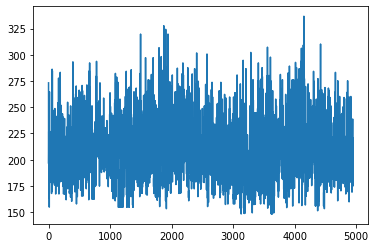

In [ ]:
plt.plot(Ts) 

In [ ]:
res_ = [156.8, 155.3, 157.8, 150.8, 141.8, 151.8, 162.3, 144.3] # r_c = 60
# res_ = [161.3, 142.3, 165.3, 155.8, 155.3, 154.8, 150.8, 156.3, 160.8, 157.3, 140.8] # r_c = 50
print(np.mean(res_))
print(np.var(res_))
# print(np.mean(c_Ts))
# print(np.var(c_Ts))
# print(np.array(coordinates))

152.6125
41.93359375


In [ ]:
action_n_ = [] 
for i in range(env.num_agents):
    action_n_.append(sorted(T_memory[i].items())[0][1][0][1])
Ts, final_rs = train_initial_action_n(-1.0, explore_stop, decay_rate, decay_step, action_n_, env, obs_prev_obs)

chosen actions  [1, 1, 1]
Explore P  0
episode  0  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  1  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  2  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  3  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  4  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  5  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  6  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  7  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  8  is  fully covered
174.3
chosen actions  [1, 1, 1]
Explore P  0
episode  9  is  fully covered
174.3
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 2. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 1. 1. 1.]
 [1. 2. 1. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 2. 1.]]

mean T =  174.3
min T =  174.3
d

In [ ]:
# print(np.min(Ts))
# print(env.index_to_pos([2, 1]))
x = T_memory[2]
print(len(T_memory[1]))
# print(T_memory[0])
print(len(Ts))
x = sorted(T_memory[0].items())
# memory = [v for k, v in sorted(T_memory[0].items(), key=lambda item: item[1])]
# y = [k for k, v in sorted(T_memory[0].items(), key=lambda item: item[1])]
first = 0
second = 3
print(x[first][0])
print(x[second][0])
print(len(x[first][1]))
print(len(x[second][1]))
for i in range(len(x[first][1])):
    if i == len(x[second][1]):
        break
    else:
        if x[first][1][i][0] == x[second][1][i][0]:
            print("state ", i, " is the same")
        else:
            print("state ", i, " is different")
# print(x[0][1][12][0], x[0][1][12][1])
# print(x[1][1][12][0], x[1][1][12][1])

185
999
142.8
147.3
21
21
state  0  is the same
state  1  is the same
state  2  is the same
state  3  is different
state  4  is different
state  5  is different
state  6  is different
state  7  is different
state  8  is different
state  9  is different
state  10  is different
state  11  is different
state  12  is different
state  13  is different
state  14  is different
state  15  is different
state  16  is different
state  17  is different
state  18  is different
state  19  is different
state  20  is different


In [ ]:
T = 142.3
for i in range(env.num_agents):
    memory = T_memory[i][T]
    print("uav ", i)
    for epr in memory:
        print(env.uavs[i].Q[epr[0]])
    print()

uav  0
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.    0.   -0.45  0.    0.    0.    0.    0.    0.  ]
[ 0.000000e+00 -4.915200e-04 -4.500000e-01 -1.572864e-04 -4.500000e-01
  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
[ 0.000000e+00  0.000000e+00 -4.500000e-01 -6.291456e-05 -4.500000e-01
  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.50000000e-01 -5.03316480e-05
 -4.50000000e-01 -3.22122547e-05 -4.50000000e-01  0.00000000e+00
  0.00000000e+00]
[ 0.    0.    0.    0.   -0.45  0.    0.    0.    0.  ]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.    0.   -0.45  0.    0.    0.    0.    0.    0.  ]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.02645612 0.         0.         0.         0.
 0.         0.         0.        ]
[0.         0.03307015 0.         0.         0.         0.
 0.         0.         0.        ]
[0.         0.08267536 0.         0.         0.         0.
 0.         0.         0.        ]
[ 0.         -0.00307

In [ ]:
print(Ts)

[212.3, 190.3, 206.3, 206.3, 201.8, 212.3, 231.8, 207.8, 215.3, 195.3, 195.8, 214.8, 178.8, 192.3, 175.8, 175.8, 205.3, 187.3, 215.3, 236.8, 245.8, 230.8, 219.8, 209.8, 203.8, 186.8, 212.8, 257.3, 232.3, 194.8, 191.8, 188.3, 236.3, 190.8, 217.8, 198.3, 186.8, 194.8, 193.3, 252.3, 225.8, 199.8, 187.8, 189.3, 186.3, 207.3, 219.3, 195.8, 221.3, 183.8, 224.8, 228.3, 245.3, 232.8, 226.3, 233.3, 210.8, 212.3, 211.8, 193.3, 195.8, 209.3, 192.8, 210.8, 196.3, 250.3, 188.8, 240.8, 269.8, 191.3, 200.3, 179.3, 198.3, 198.3, 211.8, 245.8, 211.8, 172.3, 173.3, 187.3, 187.3, 210.3, 197.8, 177.3, 279.3, 254.8, 249.8, 250.8, 275.8, 262.3, 246.3, 218.3, 202.3, 229.3, 222.3, 226.3, 182.8, 227.8, 180.3, 179.3, 197.3, 216.3, 188.8, 196.8, 176.3, 164.8, 186.8, 194.8, 187.8, 188.3, 191.3, 225.8, 225.8, 181.8, 186.3, 183.8, 227.3, 188.3, 189.8, 243.8, 229.8, 190.8, 219.3, 246.3, 240.3, 200.3, 194.8, 195.3, 182.8, 179.3, 234.3, 179.3, 188.8, 198.8, 172.3, 176.3, 186.3, 172.8, 209.3, 171.8, 178.8, 183.3, 182.8

In [ ]:
Ts2 = Ts_s

In [ ]:
print(len(Ts1[1]))
print(len(Ts3[1]))
print(Ts3[0][-1])

100
1292
184.3


In [ ]:
Ts3 = Ts_s

In [ ]:
Ts_s = [Ts1, Ts2, Ts3]

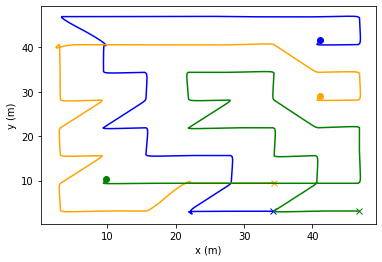

In [ ]:
# plt.plot(mean_Ts)
# plt.grid()
# plt.show()

# log_episode_interval = 10
# episodes = np.arange(log_episode_interval - 1, len(final_rs) - 1, log_episode_interval)
# episode_rewards = [np.mean(final_rs[episode - log_episode_interval + 1: episode + 1]) for episode in episodes]
# plt.plot(episode_rewards)
# plt.grid()
# plt.show()

# log_episode_interval = 50
# episodes = np.arange(log_episode_interval - 1, len(Ts) - 1, log_episode_interval)
# min_Ts = [np.min(Ts[episode - log_episode_interval + 1: episode + 1]) for episode in episodes]
# plt.plot(min_Ts)
# plt.grid()
# plt.show()

# Trajectories plot
xs_ = [[] for _ in range(env.num_agents)]
ys_ = [[] for _ in range(env.num_agents)]
for i in range(env.num_agents):
    for pos in pos_tra[i]:
        xs_[i].append(pos[0])
        ys_[i].append(pos[1])
        # print(pos)
fig, ax = plt.subplots()
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
colors = ['blue', 'orange', 'green']
for i in range(env.num_agents):
    ax.plot(xs_[i], ys_[i], label='uav ' + str(i), color=colors[i])
    # ax.plot(xs_[i][0], ys_[i][0], label='uav ' + str(i), color=colors[i], marker='o', fillstyle='none')
    ax.plot(xs_[i][0], ys_[i][0], label='uav ' + str(i), color=colors[i], marker='o')
    ax.plot(xs_[i][-1], ys_[i][-1], label='uav ' + str(i), color=colors[i], marker='x')

    # marker='o', markerfacecolor='none'
    # ax.scatter(xs_[i], ys_[i])
# ax.plot(a, d, 'k:', label='Data length')
# ax.plot(a, c + d, 'k', label='Total message length')

# legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

# print(env.uavs[0].tra_map)

# Section B
# r_c_set = np.array(range(10, 70, 10))
# labels = ["Untrained modified cooperative Q-learning algorithm", "Trained modified cooperative Q-learning algorithm", "Untrained modified independent Q-learning algorithm", "Trained modified independent Q-learning algorithm"]
# fig, ax = plt.subplots()
# ax.set_xlabel("$r_c$")
# # ax.set_ylabel(r'$\overline{T}$', rotation=0)
# ax.set_ylabel(r'$s^2$', rotation=0)
# for i in range(4):
#     if i != 2:
#         # tmp = [np.mean(Ts_s[i][j]) for j in range(len(r_c_set))]
#         tmp = [np.var(Ts_s[i][j]) for j in range(len(r_c_set))]
#     else:
#         # tmp = [Ts_s[i][j][-1] for j in range(len(r_c_set))]
#         # tmp[0] = 164.8
#         tmp = [0 for j in range(len(r_c_set))]
#     ax.plot(r_c_set, tmp, label=labels[i], marker='o', markerfacecolor='none')
#     # ax.scatter(xs_[i], ys_[i])
# # ax.plot(a, d, 'k:', label='Data length')
# # ax.plot(a, c + d, 'k', label='Total message length')

# legend = ax.legend(loc='upper right', shadow=True)
# ax.grid()

# Section C
# mean T
# fig, ax = plt.subplots()
# labels = "rc="
# ax.set_xlabel("$iterations$")
# ax.set_ylabel(r'$\overline{T}$', rotation=0)
# tmp = [[] for _ in range(3)]
# for i in range(3):
#     for j in range(0, len(Ts_s[2][i * 2 + 1]) - 99):
#         tmp[i].append(np.mean(Ts_s[2][i * 2 + 1][j:j+100]))
#     # r_c_set = np.array(range(len(Ts_s[2][i * 2 + 1]))) + 1
#     ax.plot(tmp[i], label= labels + str((i + 1) * 20))
# legend = ax.legend(loc='upper right', shadow=True)

# learning curves
# log_episode_interval = 10
# fig, ax = plt.subplots()
# labels = "rc="
# ax.set_xlabel("$episode$")
# ax.set_ylabel("$r$", rotation=0)
# for i in range(3):
#     episodes = np.arange(log_episode_interval - 1, len(final_rs_s[i * 2 + 1]) - 1, log_episode_interval)
#     episode_rewards = [np.mean(final_rs_s[i * 2 + 1][episode - log_episode_interval + 1: episode + 1]) for episode in episodes]
#     ax.plot(episode_rewards, label = labels + str((i + 1) * 20))
# legend = ax.legend(loc='upper left', shadow=True)


# plt.xlabel("$r_c$")
# plt.ylabel(r'$\overline{T}$', rotation=0)
# plt.show()

# plt.plot(r_c_set, var_Ts) 
# plt.xlabel("$r_c$")
# plt.ylabel(r'$s^2$', rotation=0)